In [1]:
import pandas as pd
import numpy as np
import os
import string
from collections import Counter
SNLI_train = pd.read_csv('snli_train.tsv', sep= '\t')
SNLI_val = pd.read_csv('snli_val.tsv', sep= '\t')
print('Train data setlength: ' + str(len(SNLI_train)))
print('Val dataset length: '+str(len(SNLI_val)))
SNLI_train.head()

Train data setlength: 100000
Val dataset length: 1000


sentence1  \
0  A young girl in a pink shirt sitting on a dock...   
1  A woman is smiling while the man next to her i...   
2  Across the river , you can see a large building .   
3  a man in white shorts and a black shirt is par...   
4  Four black dogs run together on bright green g...   

                                           sentence2          label  
0  A young girl watching the sunset over the water .        neutral  
1                Two people are next to each other .     entailment  
2  The large building is full of apartments and t...        neutral  
3            A man is riding a jetski on the ocean .  contradiction  
4  Four dogs are preparing to be launched into sp...  contradiction

## Read Data and create word dictionary from fasttext

In [2]:
SNLI_train['label'] = SNLI_train['label'].astype('category')
y_train = SNLI_train['label'].cat.codes.tolist()
SNLI_val['label'] = SNLI_val['label'].astype('category')
y_val = SNLI_val['label'].cat.codes.tolist()
print(Counter(y_train))
print(Counter(SNLI_train['label']))
print(Counter(y_val))
print(Counter(SNLI_val['label']))

Counter({1: 33635, 2: 33200, 0: 33165})
Counter({'entailment': 33635, 'neutral': 33200, 'contradiction': 33165})
Counter({2: 338, 0: 331, 1: 331})
Counter({'neutral': 338, 'contradiction': 331, 'entailment': 331})


In [3]:
# Load embedding vectors from fasttext and create word dictionary
words_to_load = 50000
PAD_IDX = 0
UNK_IDX = 1
unk_embedding = np.random.rand(300)
unk_embedding = (unk_embedding-unk_embedding.mean())/unk_embedding.std()
with open('wiki-news-300d-1M.vec','rb') as f:
    loaded_embeddings_ft = np.zeros((words_to_load+2, 300))
    words_ft = {}
    idx2words_ft = {}
    ordered_words_ft = []
    words_ft['<pad>'] = PAD_IDX
    words_ft['<unk>'] = UNK_IDX
    idx2words_ft[PAD_IDX] = '<pad>'
    idx2words_ft[UNK_IDX] = '<unk>'
    ordered_words_ft.append('<pad>')
    ordered_words_ft.append('<unk>')
    loaded_embeddings_ft[1,:]=unk_embedding
    for i, line in enumerate(f):
        line = line.decode('utf-8')
        if i >= words_to_load: 
            break
        s = line.split()
        loaded_embeddings_ft[i+2, :] = np.asarray(s[1:])
        words_ft[s[0]] = i+2
        idx2words_ft[i+2] = s[0]
        ordered_words_ft.append(s[0])

## Token to vectors according to word dictionary (Lookup)

In [4]:
def sentence2index_dataset(data):
    indices_data = []
    for line in data:
        tokens = line.split()
        index_list = [words_ft[word] if word in ordered_words_ft else UNK_IDX for word in tokens]
        indices_data.append(index_list)
    return indices_data
sent1_indices_train = sentence2index_dataset(SNLI_train['sentence1'].tolist())
sent2_indices_train = sentence2index_dataset(SNLI_train['sentence2'].tolist())
sent1_indices_val = sentence2index_dataset(SNLI_val['sentence1'].tolist())
sent2_indices_val = sentence2index_dataset(SNLI_val['sentence2'].tolist())

In [5]:
MNLI_train = pd.read_csv('mnli_train.tsv', sep= '\t')
MNLI_val = pd.read_csv('mnli_val.tsv', sep= '\t')
print('Train data setlength: ' + str(len(MNLI_train)))
print('Val dataset length: '+str(len(MNLI_val)))
MNLI_train.head()

Train data setlength: 20000
Val dataset length: 5000


sentence1  \
0  and now that was in fifty one that 's forty ye...   
1  Jon could smell baked bread on the air and his...   
2  it will be like Italian basketball with the uh...   
3  well i think that 's about uh that 's about co...   
4  Good job tenure , that is -- because in yet an...   

                                           sentence2          label      genre  
0  It was already a problem forty years ago but n...        neutral  telephone  
1         Jon smelt food in the air and was hungry .        neutral    fiction  
2  This type of Italian basketball is nothing lik...  contradiction  telephone  
3               Sorry but we are not done just yet .  contradiction  telephone  
4  Dr. Quinn , Medicine Woman , was worked on by ...     entailment      slate

In [6]:
import torch
if torch.cuda.is_available and torch.has_cudnn:
    device = torch.device('cuda')
else:
    device = torch.device("cpu")
print(device)

cuda


## Data loader and sort

In [7]:
MAX_SENTENCE_LENGTH = 100

import numpy as np

from torch.utils.data import Dataset

class SNLIDataset(Dataset):

    def __init__(self, data_list_1, data_list_2, target_list):
  
        self.data_list_1 = data_list_1
        self.data_list_2 = data_list_2
        self.target_list = target_list
        assert (len(self.data_list_1) == len(self.data_list_2))

    def __len__(self):
        return len(self.data_list_1)
        
    def __getitem__(self, key):
        
        token_idx_1 = self.data_list_1[key][:MAX_SENTENCE_LENGTH]
        token_idx_2 = self.data_list_2[key][:MAX_SENTENCE_LENGTH]
        label = self.target_list[key]
        return [token_idx_1,token_idx_2, len(token_idx_1), len(token_idx_2) , label]

def snli_collate_func(batch):

    data_list_1 = []
    data_list_2 = []
    label_list = []
    length_list1 = []
    length_list2 = []
    for datum in batch:
        label_list.append(datum[4])
        length_list1.append(datum[2])
        length_list2.append(datum[3])
    # padding
    for datum in batch:
        padded_vec1 = np.pad(np.array(datum[0]), 
                                pad_width=((0,MAX_SENTENCE_LENGTH-datum[2])), 
                                mode="constant", constant_values=0)
        data_list_1.append(padded_vec1)
        padded_vec2 = np.pad(np.array(datum[1]), 
                                pad_width=((0,MAX_SENTENCE_LENGTH-len(datum[1]))), 
                                mode="constant", constant_values=0)
        data_list_2.append(padded_vec2)
    # sort by the length of sentence 1, so we need only one more sort of sentence 2 in RNN
    ind_dec_order = np.argsort(length_list1)[::-1]
    data_list_1 = np.array(data_list_1)[ind_dec_order]
    data_list_2 = np.array(data_list_2)[ind_dec_order]
    length_list_1 = np.array(length_list1)[ind_dec_order]
    length_list_2 = np.array(length_list2)[ind_dec_order]
    label_list = np.array(label_list)[ind_dec_order]
    
    return [torch.from_numpy(np.array(data_list_1)).to(device),
            torch.from_numpy(np.array(data_list_2)).to(device),
            torch.LongTensor(length_list_1).to(device),torch.LongTensor(length_list_2).to(device),
            torch.LongTensor(label_list).to(device)]

BATCH_SIZE = 128
train_dataset = SNLIDataset(sent1_indices_train, sent2_indices_train, y_train)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                           batch_size=BATCH_SIZE,
                                           collate_fn=snli_collate_func,
                                           shuffle=True)

val_dataset = SNLIDataset(sent1_indices_val, sent2_indices_val, y_val)
val_loader = torch.utils.data.DataLoader(dataset=val_dataset, 
                                           batch_size=BATCH_SIZE,
                                           collate_fn=snli_collate_func,
                                           shuffle=True)

## RNN

In [8]:
#storing accuracy and loss when tuning the model
fine_tuning = {}
fine_tuning['val_loss'] = {}
fine_tuning['train_loss'] = {}
fine_tuning['val_acc'] = {}
fine_tuning['train_acc'] = {}

In [9]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class RNNEncoder(nn.Module):
    # Encode a sentence with gru
    def  __init__(self, input_size, hidden_size, num_layers):
        super(RNNEncoder, self).__init__()
        self.hidden_size = hidden_size
        self.dropout = nn.Dropout(p=0.2)
        self.num_layers = num_layers
        self.bi_gru = nn.GRU(input_size, hidden_size, num_layers, batch_first=True, bidirectional = True)
    def init_hidden(self, batch_size):
        hidden = torch.randn(self.num_layers*2, batch_size, self.hidden_size)
        return hidden.to(device)
    def forward(self, x, lengths):
        # reset hidden state
        batch_size, seq_len, emd_dim = x.size()
        self.hidden = self.init_hidden(batch_size)
        rnn_out = torch.nn.utils.rnn.pack_padded_sequence(x, lengths.cpu().numpy(), batch_first=True)
        rnn_out, self.hidden = self.bi_gru(rnn_out, self.hidden)
        self.hidden = self.dropout(self.hidden)
        #concate two layer output of bidirectional gru
        out = torch.cat([self.hidden[0,:,:],self.hidden[1,:,:]],dim = 1)
        return out
        
# map word vectors to embedding layer
def create_emb_layer(weights_matrix, non_trainable=False):
    num_embeddings, embedding_dim = weights_matrix.shape
    emb_layer = nn.Embedding(num_embeddings, embedding_dim)
    emb_layer.load_state_dict({'weight': weights_matrix})
    if non_trainable:
        emb_layer.weight.requires_grad = False
    return emb_layer, num_embeddings, embedding_dim

class RNN(nn.Module):
    def __init__(self, weights_matrix, input_size, hidden_size, num_layers, num_classes):
        super(RNN, self).__init__()
        self.embedding, num_embeddings, embedding_dim = create_emb_layer(weights_matrix, True)
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.rnn_encoder_1 = RNNEncoder(input_size, hidden_size, num_layers)
        self.rnn_encoder_2 = RNNEncoder(input_size, hidden_size, num_layers)
        self.fc1 = nn.Linear(hidden_size*2, hidden_size)
        self.fc2 = nn.Linear(hidden_size,num_classes)
        
    def forward(self, data_1, data_2, lengths_1, lengths_2):
        embed_1 = self.embedding(data_1)
        embed_2 = self.embedding(data_2)
        encoded_data_1 = self.rnn_encoder_1(embed_1,lengths_1)
        # sort sentence 2 in descending order
        sorted_lengths, indices_decs = torch.sort(lengths_2,descending=True)
        embed_2 = embed_2[indices_decs,:,:]
        _, inverse_indx = torch.sort(indices_decs)
        encoded_data_2 = self.rnn_encoder_2(embed_2,sorted_lengths)
        # inverse sorting sentence 2 that consistent to the order of sentence 1
        encoded_data_2 = encoded_data_2[inverse_indx,:]
        # Mapping two sentences together
#         data = torch.cat([encoded_data_1, encoded_data_2], 1)
        data = encoded_data_1 * encoded_data_2
        # Fully connected layer
        out = F.relu(self.fc1(data))
        out = self.fc2(out)
        return out
    
# compute accuracy
def test_model(loader, model):
    correct = 0
    total = 0
    model.eval()
    count = 0
    for data_1, data_2, lengths_1, lengths_2, labels in loader:
        count += 1
        if count > 100:
            break
        data_batch_1,data_batch_2, lengths_batch_1,lengths_batch_2, label_batch = data_1, data_2, lengths_1, lengths_2, labels
        data_batch_1 = data_batch_1.long()
        data_batch_2 = data_batch_2.long()
        outputs = F.softmax(model(data_batch_1, data_batch_2, lengths_batch_1,lengths_batch_2), dim=1)
        predicted = outputs.max(1, keepdim=True)[1]
        total += labels.size(0)
        correct += predicted.eq(labels.view_as(predicted)).sum().item()
    return (100 * correct / total)

# compute validation loss
def validation_loss(loader,model):
    loss = 0
    count = 0
    for data_1, data_2, lengths_1, lengths_2, labels in loader:
        outputs = model(data_1,data_2, lengths_1, lengths_2)
        loss += float(criterion(outputs, labels))
        count += 1
    return loss/count

pre_trained_embedding = torch.from_numpy(loaded_embeddings_ft).float()
model = RNN(weights_matrix=pre_trained_embedding, input_size=300, hidden_size=300, num_layers=1, num_classes=3)


In [10]:
learning_rate = 1e-3
num_epochs = 50 # number epoch to train

hyperparameter = 'best'


# Criterion and Optimizer
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=0)

# Train the model
total_step = len(train_loader)
train_accuracy = []
valid_accuracy = []
val_loss = []
train_loss = []
model.to(device)
max_acc = 0
for epoch in range(num_epochs):
    for i, (data_1, data_2, lengths_1, lengths_2, labels) in enumerate(train_loader):
        model.train()
        optimizer.zero_grad()
        # Forward pass
        data_1 = data_1.long()
        data_2 = data_2.long()
        outputs = model(data_1,data_2, lengths_1, lengths_2)
        labels = labels.long()
        loss = criterion(outputs, labels)
        # Backward and optimize
        loss.backward()
        optimizer.step()
        # validate every 100 iterations
        if i > 0 and i % 100 == 0:
            # validate
            val_acc = test_model(val_loader, model)
            pytorch_total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
            print('Epoch: [{}/{}], Step: [{}/{}], Validation Acc: {}, number of Para: {}'.format(
                       epoch+1, num_epochs, i+1, len(train_loader), val_acc, pytorch_total_params))
            train_acc = test_model(train_loader, model)
            train_accuracy.append(train_acc)
            valid_accuracy.append(val_acc)
            if val_acc > 73 and val_acc > max_acc:
                torch.save(model.state_dict(), 'rnn_model.pt')
                print('Better Model Saved')
                max_acc = val_acc
            train_loss.append(float(loss))
            val_loss.append(validation_loss(val_loader, model))
    if (train_acc - val_acc) > 25:
        break
fine_tuning['val_loss'][hyperparameter] = val_loss
fine_tuning['train_loss'][hyperparameter] = train_loss
fine_tuning['val_acc'][hyperparameter] = valid_accuracy
fine_tuning['train_acc'][hyperparameter] = train_accuracy

Epoch: [1/50], Step: [101/782], Validation Acc: 51.4, number of Para: 2348403
Epoch: [1/50], Step: [201/782], Validation Acc: 56.2, number of Para: 2348403
Epoch: [1/50], Step: [301/782], Validation Acc: 55.4, number of Para: 2348403
Epoch: [1/50], Step: [401/782], Validation Acc: 55.2, number of Para: 2348403
Epoch: [1/50], Step: [501/782], Validation Acc: 57.6, number of Para: 2348403
Epoch: [1/50], Step: [601/782], Validation Acc: 57.7, number of Para: 2348403
Epoch: [1/50], Step: [701/782], Validation Acc: 60.7, number of Para: 2348403
Epoch: [2/50], Step: [101/782], Validation Acc: 61.4, number of Para: 2348403
Epoch: [2/50], Step: [201/782], Validation Acc: 61.8, number of Para: 2348403
Epoch: [2/50], Step: [301/782], Validation Acc: 64.0, number of Para: 2348403
Epoch: [2/50], Step: [401/782], Validation Acc: 63.2, number of Para: 2348403
Epoch: [2/50], Step: [501/782], Validation Acc: 63.0, number of Para: 2348403
Epoch: [2/50], Step: [601/782], Validation Acc: 62.2, number of 

In [53]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

## Plots of fine tuning RNN

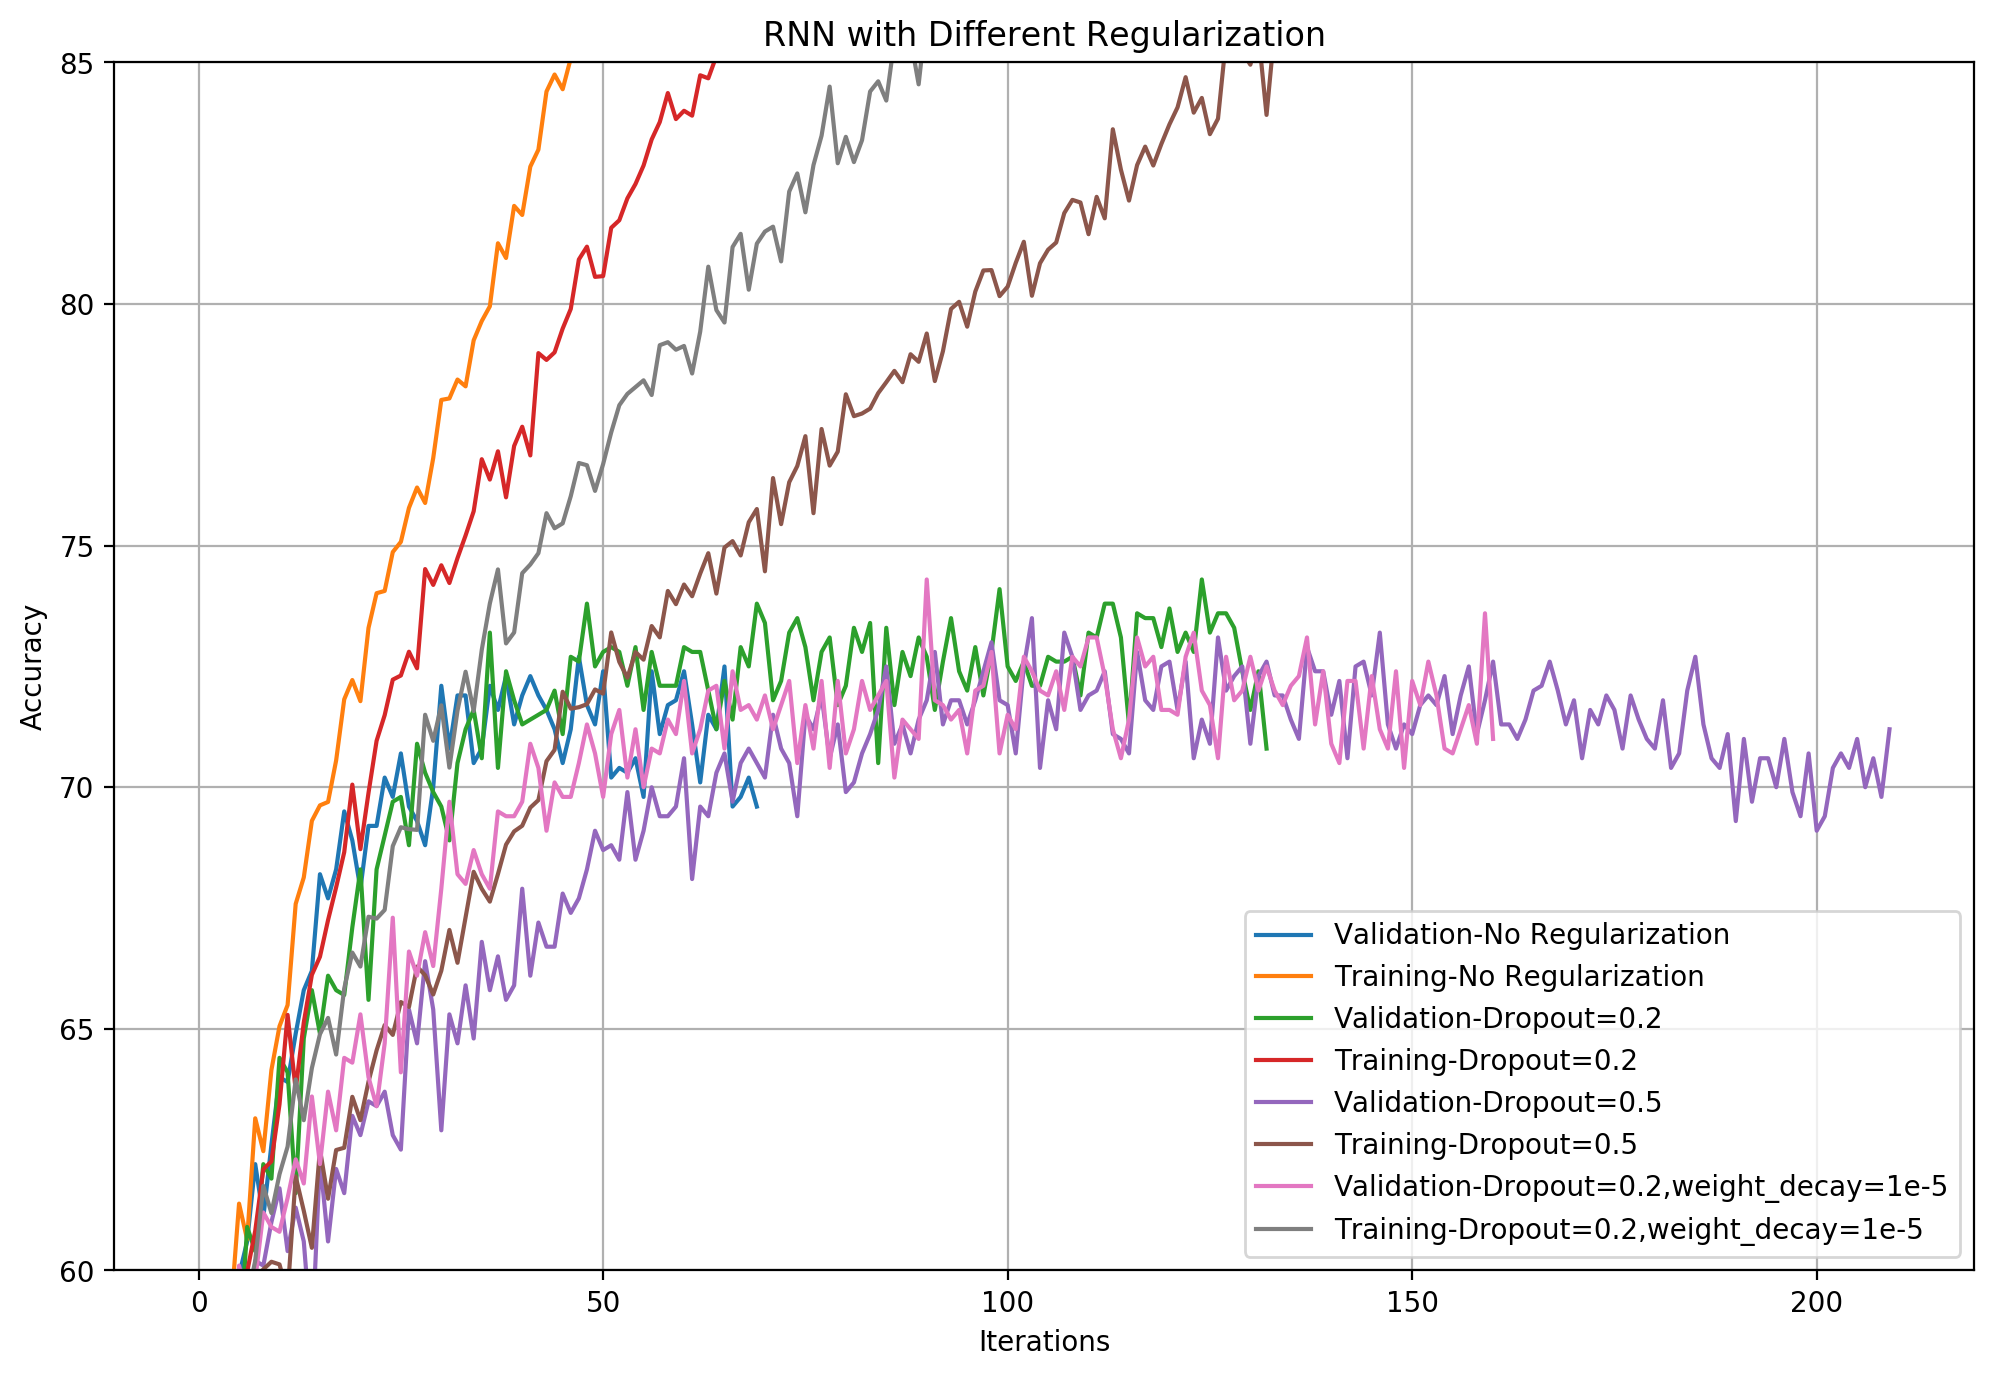

In [65]:

figure(num=None, figsize=(12, 8), dpi=200)
plt.plot(fine_tuning['val_acc']['300'])
plt.plot(fine_tuning['train_acc']['300'])
plt.plot(fine_tuning['val_acc']['300，drop=0.2'])
plt.plot(fine_tuning['train_acc']['300，drop=0.2'])
plt.plot(fine_tuning['val_acc']['300，drop=0.5'])
plt.plot(fine_tuning['train_acc']['300，drop=0.5'])
plt.plot(fine_tuning['val_acc']['300，drop=0.2，decay=1e-5'])
plt.plot(fine_tuning['train_acc']['300，drop=0.2，decay=1e-5'])
plt.title('RNN with Different Regularization')
plt.legend(('Validation-No Regularization','Training-No Regularization','Validation-Dropout=0.2',
            'Training-Dropout=0.2','Validation-Dropout=0.5',
            'Training-Dropout=0.5', 'Validation-Dropout=0.2,weight_decay=1e-5',
            'Training-Dropout=0.2,weight_decay=1e-5'),
          loc='lower right')
plt.ylabel('Accuracy')
plt.xlabel('Iterations')
plt.grid()
plt.ylim((60,85))
plt.show()

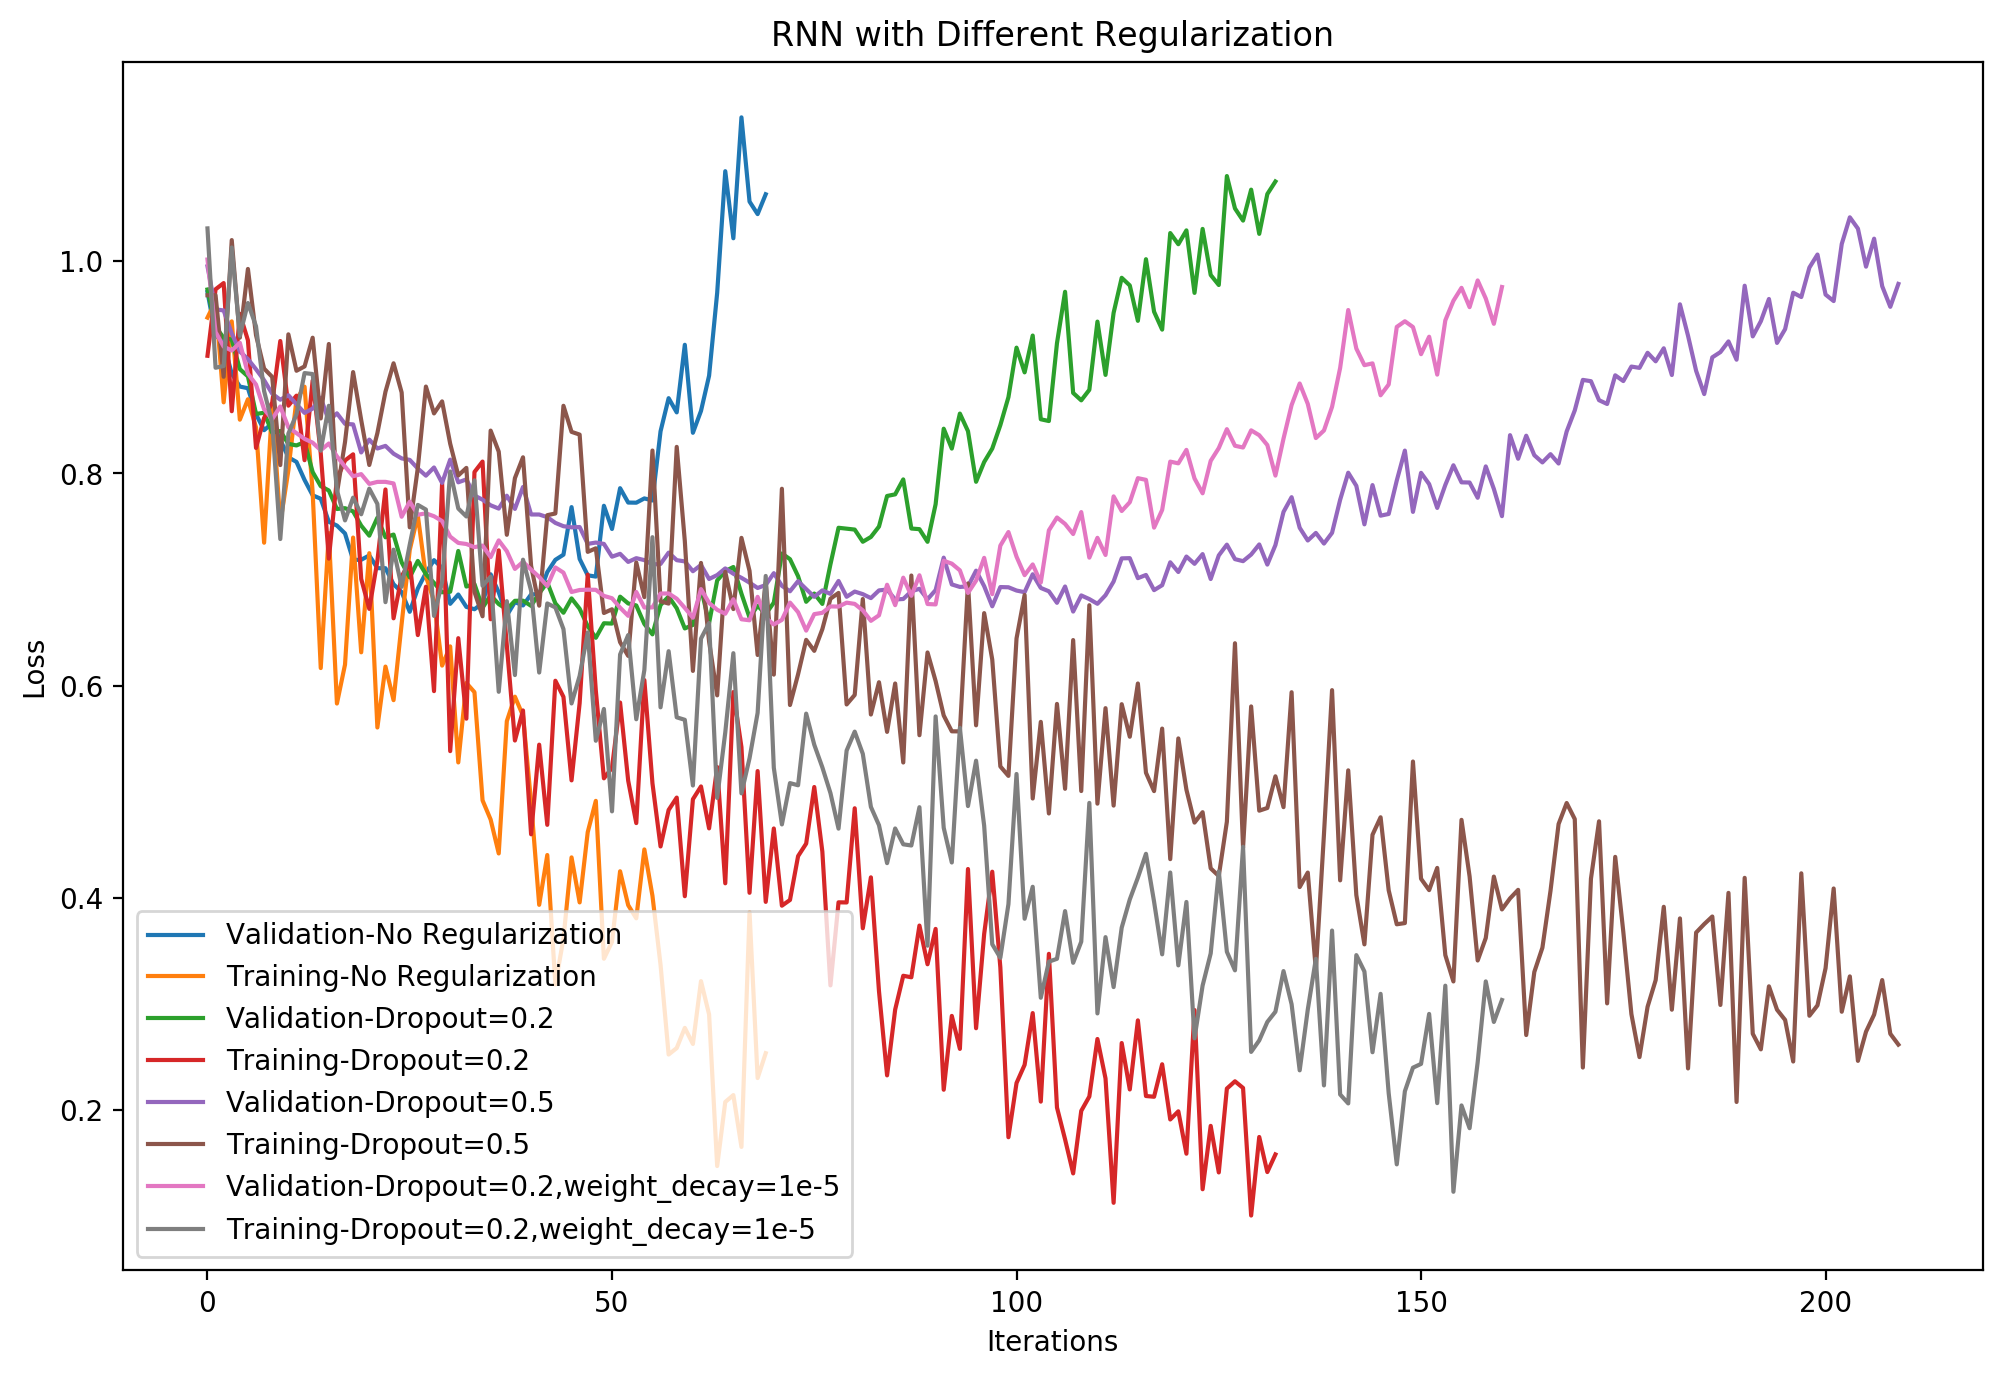

In [69]:

figure(num=None, figsize=(12, 8), dpi=200)
plt.plot(fine_tuning['val_loss']['300'])
plt.plot(fine_tuning['train_loss']['300'])
plt.plot(fine_tuning['val_loss']['300，drop=0.2'])
plt.plot(fine_tuning['train_loss']['300，drop=0.2'])
plt.plot(fine_tuning['val_loss']['300，drop=0.5'])
plt.plot(fine_tuning['train_loss']['300，drop=0.5'])
plt.plot(fine_tuning['val_loss']['300，drop=0.2，decay=1e-5'])
plt.plot(fine_tuning['train_loss']['300，drop=0.2，decay=1e-5'])
plt.title('RNN with Different Regularization')
plt.legend(('Validation-No Regularization','Training-No Regularization','Validation-Dropout=0.2',
            'Training-Dropout=0.2','Validation-Dropout=0.5',
            'Training-Dropout=0.5', 'Validation-Dropout=0.2,weight_decay=1e-5',
            'Training-Dropout=0.2,weight_decay=1e-5'),
          loc='lower left')
plt.ylabel('Loss')
plt.xlabel('Iterations')
plt.show()

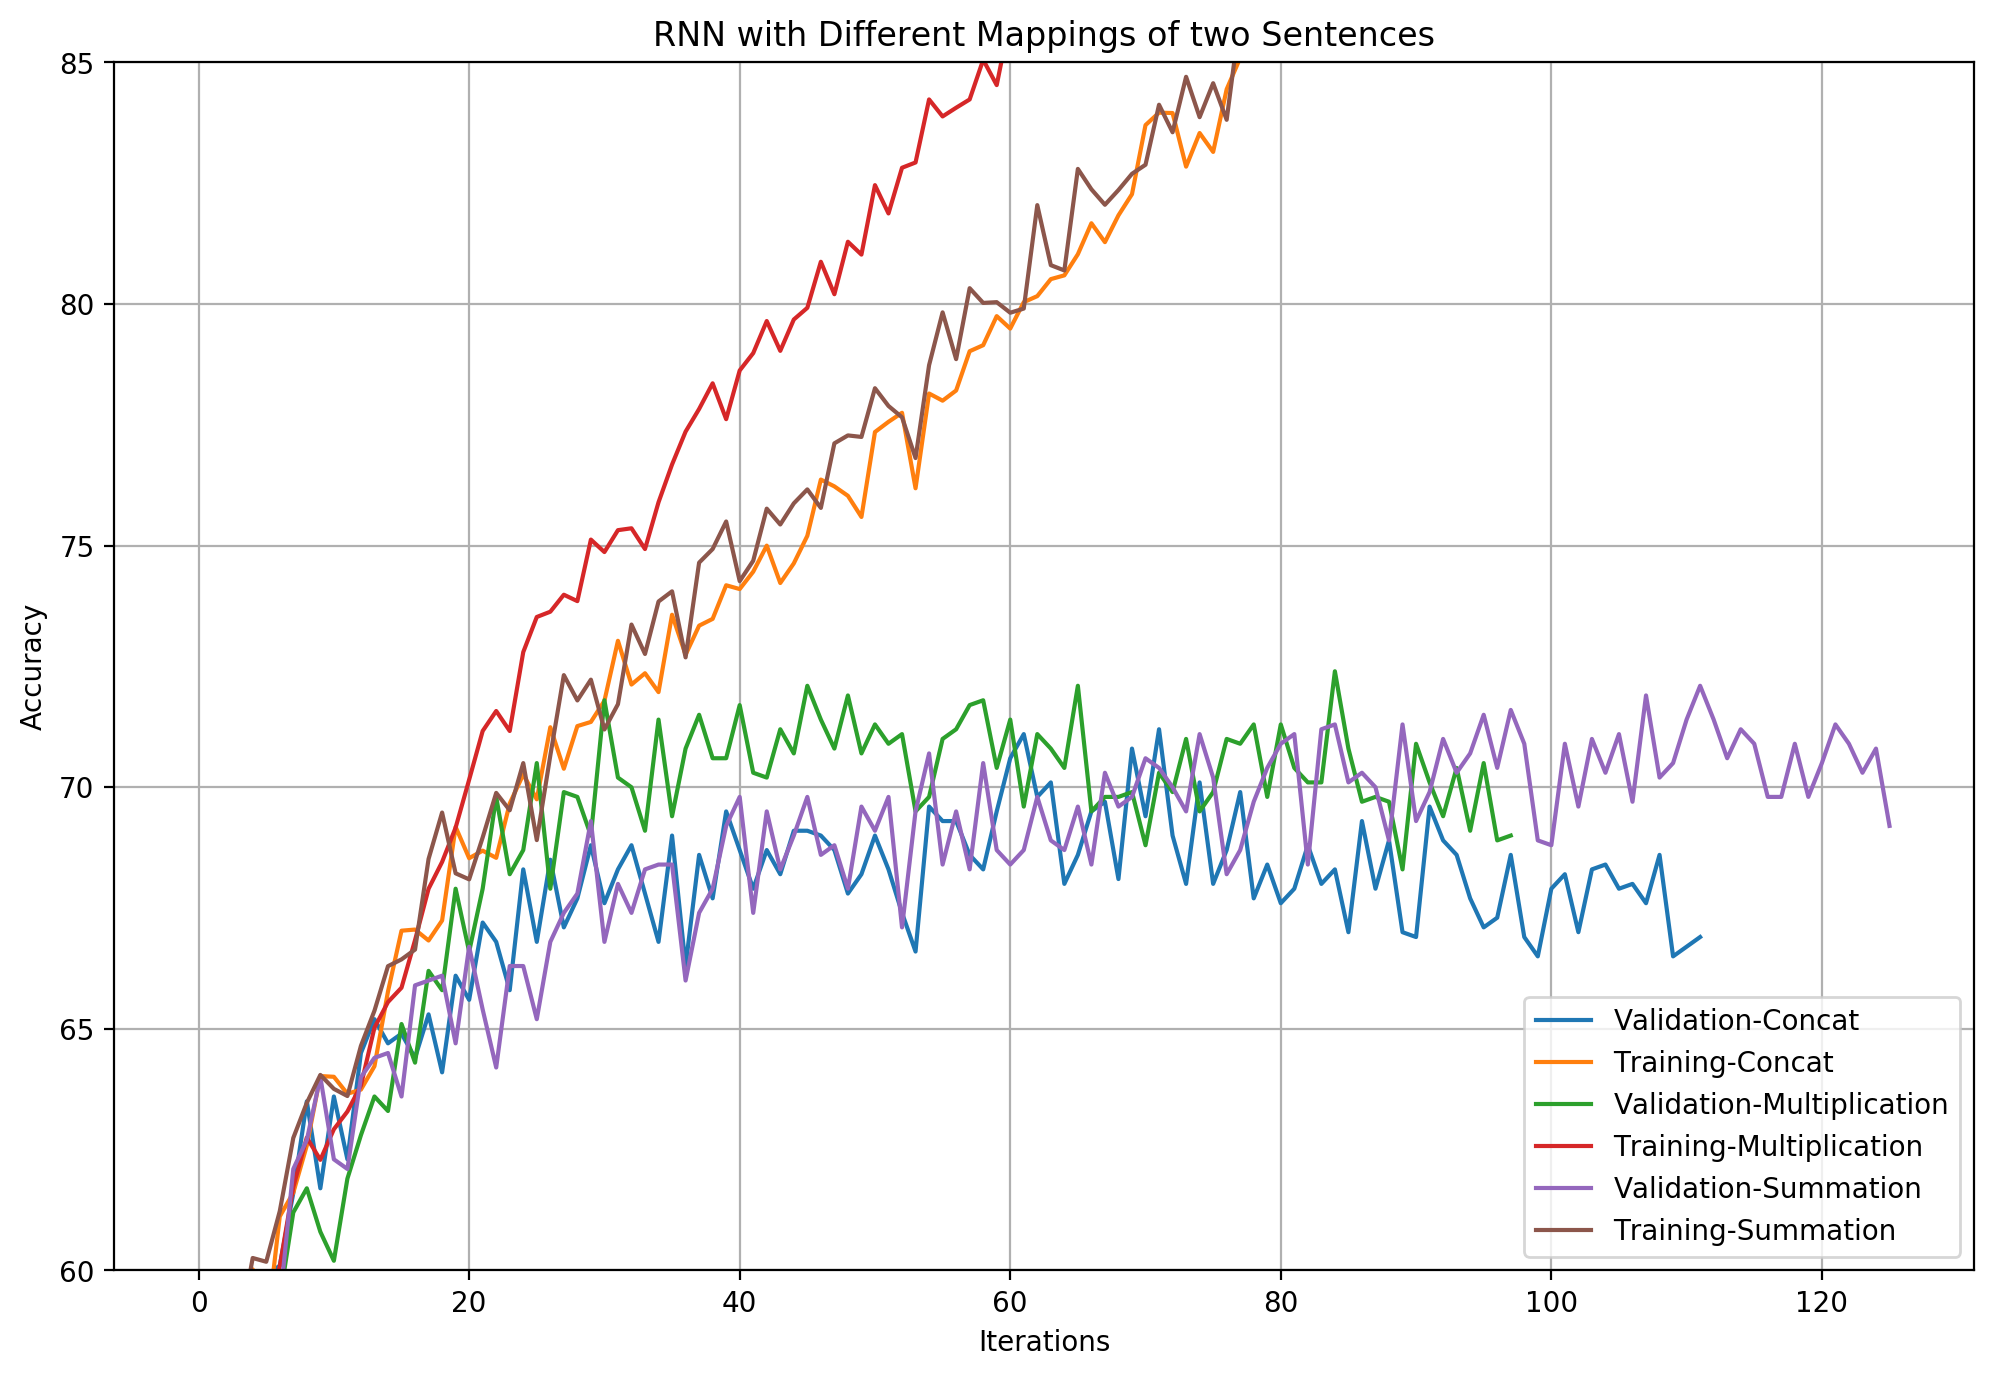

In [57]:
figure(num=None, figsize=(12, 8), dpi=200)
plt.plot(fine_tuning['val_acc']['300,concat'])
plt.plot(fine_tuning['train_acc']['300,concat'])
plt.plot(fine_tuning['val_acc']['300'])
plt.plot(fine_tuning['train_acc']['300'])
plt.plot(fine_tuning['val_acc']['300,sum'])
plt.plot(fine_tuning['train_acc']['300,sum'])
plt.title('RNN with Different Mappings of two Sentences')
plt.legend(('Validation-Concat','Training-Concat','Validation-Multiplication','Training-Multiplication',
           'Validation-Summation','Training-Summation'),
          loc='lower right')
plt.ylabel('Accuracy')
plt.xlabel('Iterations')
plt.grid()
plt.ylim((60,85))
plt.show()

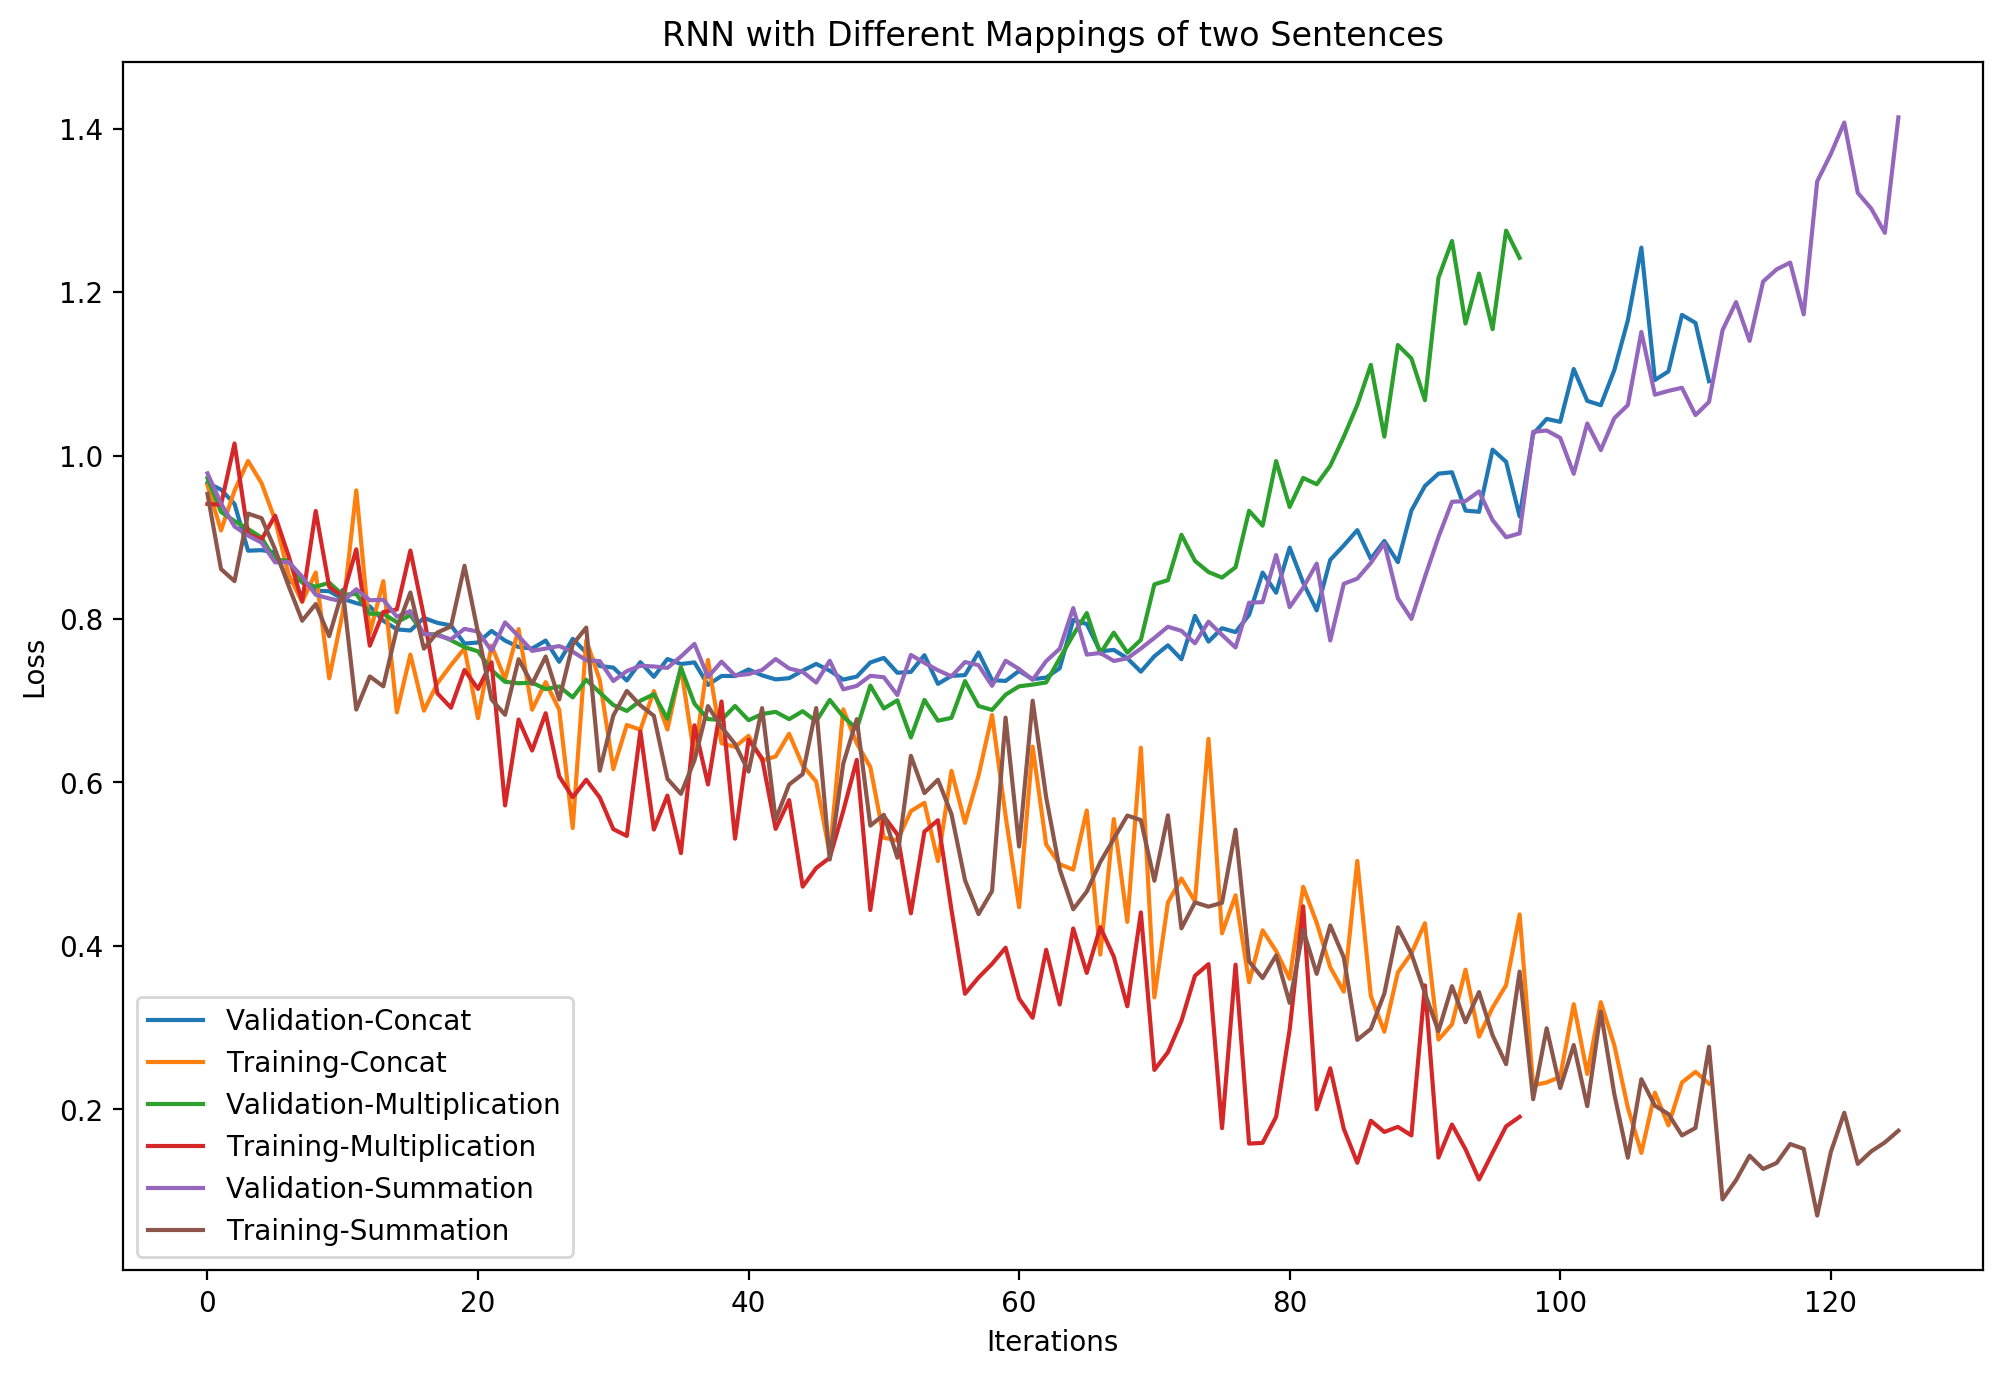

In [58]:
figure(num=None, figsize=(12, 8), dpi=200)
plt.plot(fine_tuning['val_loss']['300,concat'])
plt.plot(fine_tuning['train_loss']['300,concat'])
plt.plot(fine_tuning['val_loss']['300'])
plt.plot(fine_tuning['train_loss']['300'])
plt.plot(fine_tuning['val_loss']['300,sum'])
plt.plot(fine_tuning['train_loss']['300,sum'])
plt.title('RNN with Different Mappings of two Sentences')
plt.legend(('Validation-Concat','Training-Concat','Validation-Multiplication','Training-Multiplication',
           'Validation-Summation','Training-Summation'),
          loc='lower left')
plt.ylabel('Loss')
plt.xlabel('Iterations')
plt.show()

In [73]:
figure(num=None, figsize=(12, 8), dpi=200)

# plt.plot(fine_tuning['val_acc']['hidden_size=50'])
# plt.plot(fine_tuning['train_acc']['hidden_size=50'])
plt.plot(fine_tuning['val_acc']['hidden_size=100'])
plt.plot(fine_tuning['train_acc']['hidden_size=100'])
plt.plot(fine_tuning['val_acc']['hidden_size=300,1200,600'])
plt.plot(fine_tuning['train_acc']['hidden_size=300,1200,600'])
plt.plot(fine_tuning['val_acc']['hidden_size=500'])
plt.plot(fine_tuning['train_acc']['hidden_size=500'])
plt.grid()
plt.title('RNN with Different Hidden Layer Size')
plt.legend(('100-Validation','100-Training','300-Validation','300-Training',
            '500-Validation','500-Training'),loc = 'lower right')
plt.show()

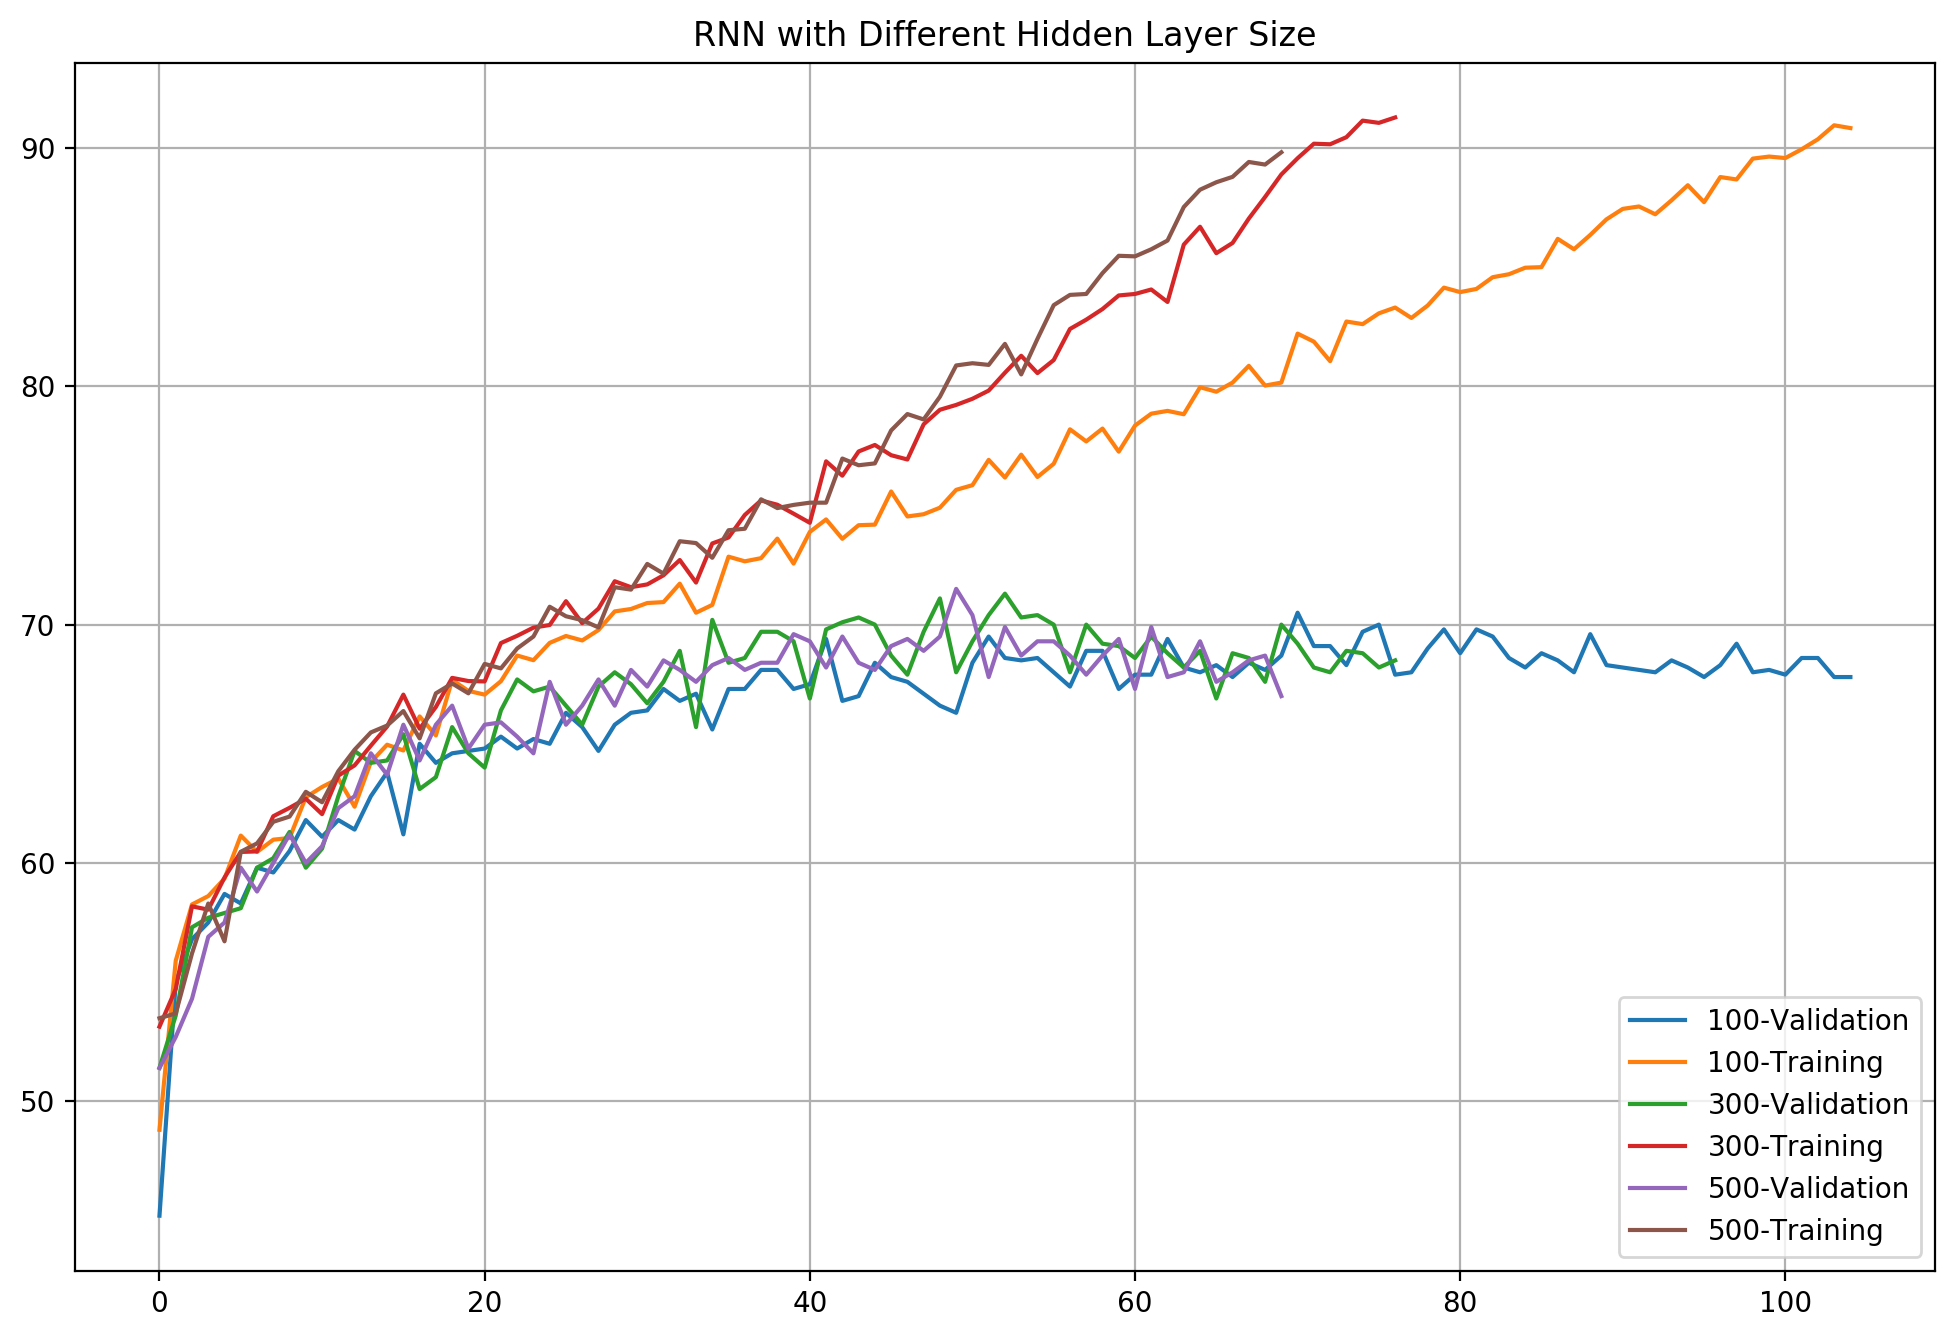

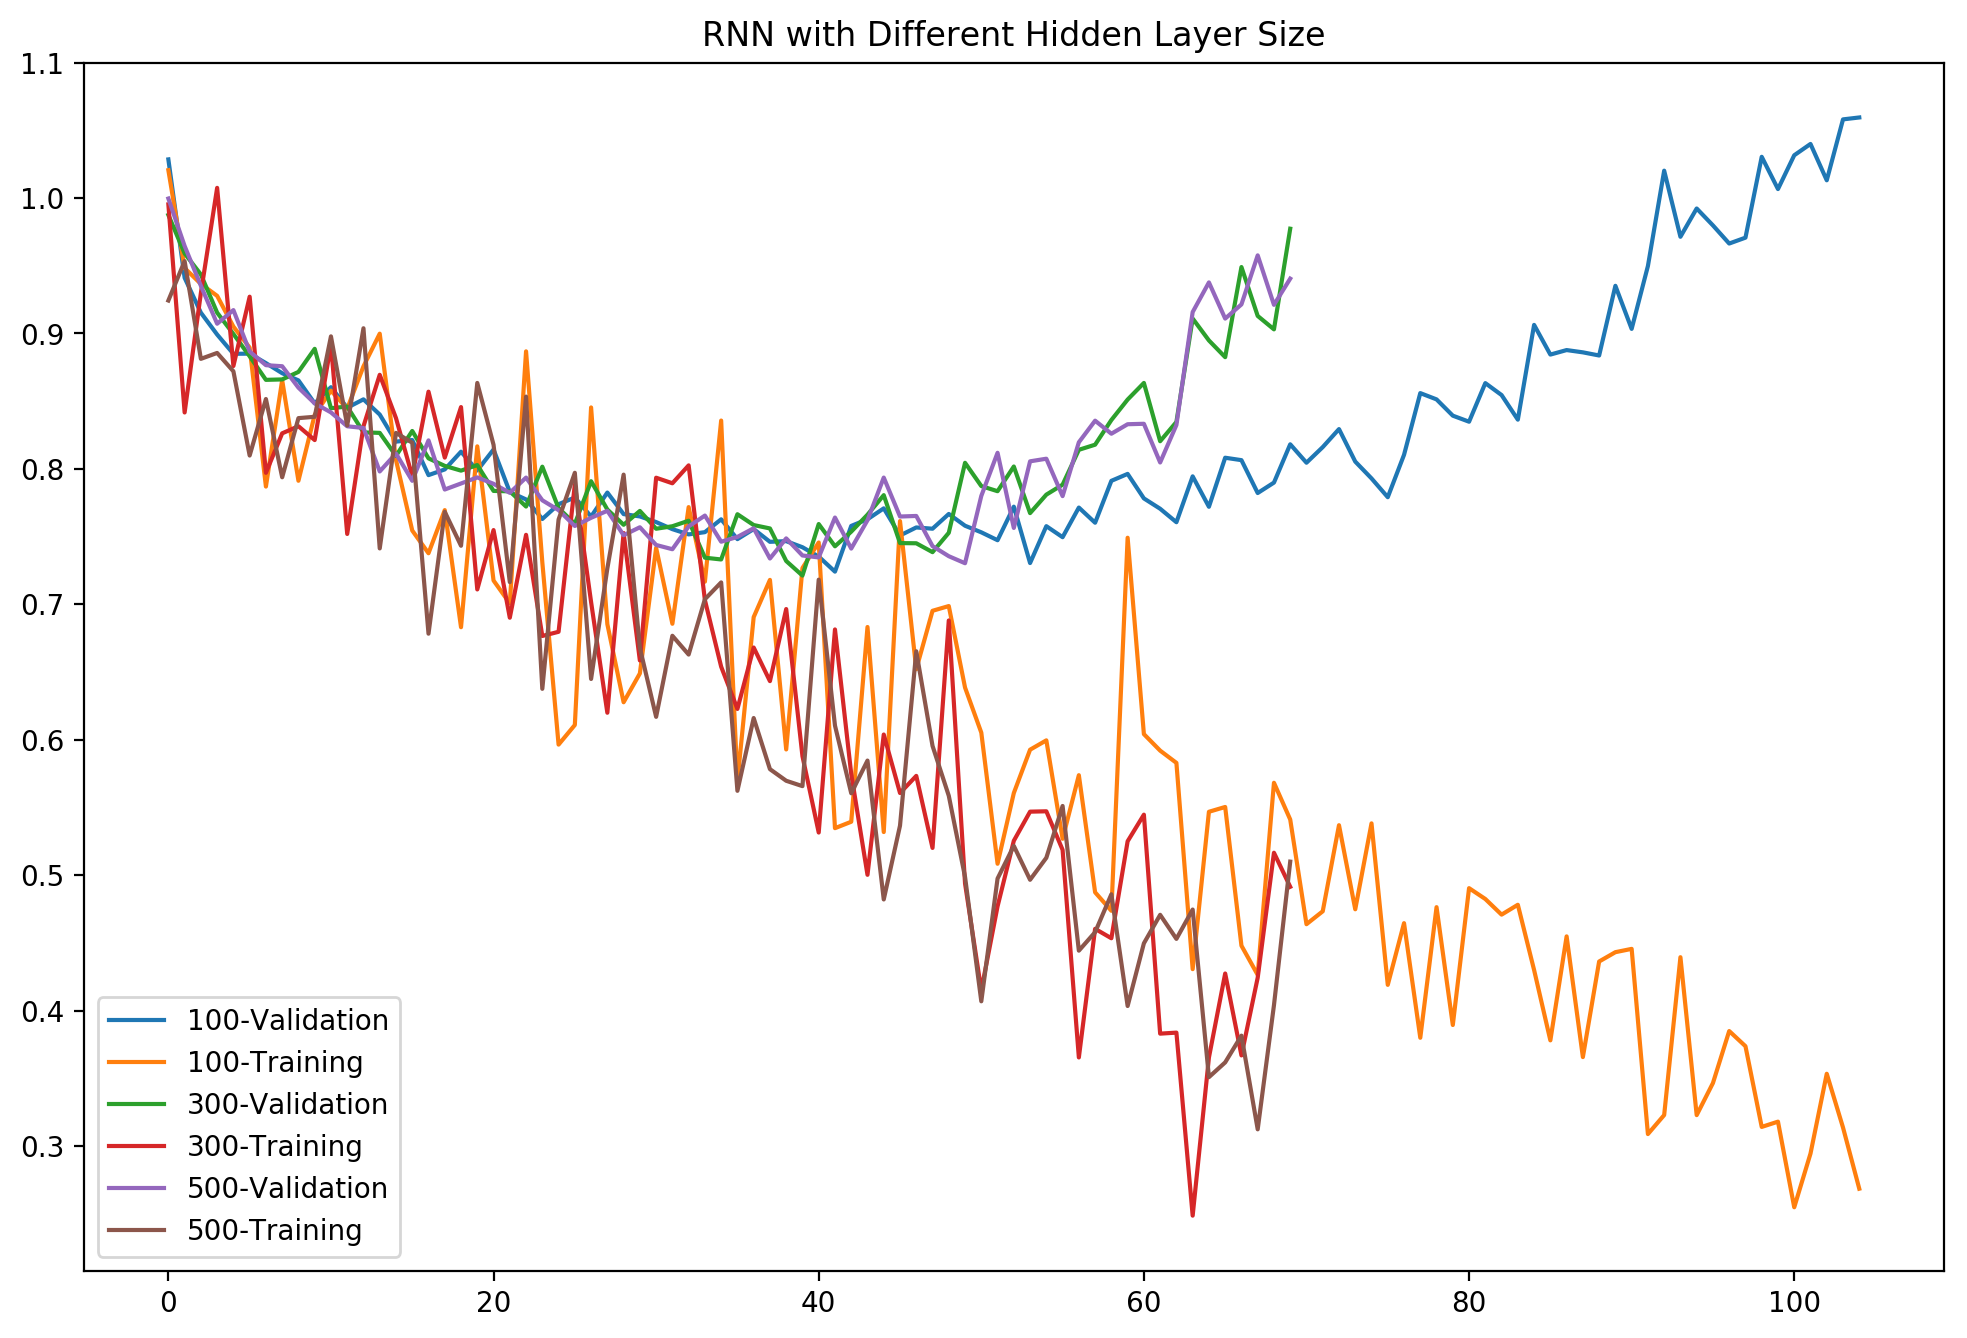

In [32]:
figure(num=None, figsize=(12, 8), dpi=200)
# plt.plot(fine_tuning['val_loss']['hidden_size=50'])
# plt.plot(fine_tuning['train_loss']['hidden_size=50'])
plt.plot(fine_tuning['val_loss']['hidden_size=100'])
plt.plot(fine_tuning['train_loss']['hidden_size=100'])
plt.plot(fine_tuning['val_loss']['hidden_size=300'])
plt.plot(fine_tuning['train_loss']['hidden_size=300'])
plt.plot(fine_tuning['val_loss']['hidden_size=500'])
plt.plot(fine_tuning['train_loss']['hidden_size=500'])
plt.title('RNN with Different Hidden Layer Size')
plt.legend(('100-Validation','100-Training','300-Validation','300-Training',
            '500-Validation','500-Training'),loc = 'lower left')
plt.show()

In [13]:
fine_tuning_CNN = {}
fine_tuning_CNN['val_loss'] = {}
fine_tuning_CNN['train_loss'] = {}
fine_tuning_CNN['val_acc'] = {}
fine_tuning_CNN['train_acc'] = {}

## CNN

In [14]:
import torch
import torch.nn as nn
import torch.nn.functional as F


class CNN(nn.Module):
    def __init__(self, weights_matrix, hidden_size, num_layers ,num_classes):
        super(CNN, self).__init__()
        self.cnn_encoder = CNNEncoder(weights_matrix, hidden_size, num_layers)
        self.fc1 = nn.Linear(hidden_size*2, hidden_size)
        self.fc2 = nn.Linear(hidden_size,num_classes)
        
    def forward(self, data_1, data_2):
        # encode two sentences with CNN
        encoded_data_1 = self.cnn_encoder(data_1)
        encoded_data_2 = self.cnn_encoder(data_2)
        # map two sentences together
        data = torch.cat([encoded_data_1,encoded_data_2],1)
#         data = encoded_data_1 * encoded_data_2
        # two full connected layers
        out = F.relu(self.fc1(data))
        out = self.fc2(out)
        return out

# map lookup layer to embedding layer
def create_emb_layer(weights_matrix, non_trainable=False):
    num_embeddings, embedding_dim = weights_matrix.shape
    emb_layer = nn.Embedding(num_embeddings, embedding_dim, padding_idx=PAD_IDX)
    emb_layer.load_state_dict({'weight': weights_matrix})
    if non_trainable:
        emb_layer.weight.requires_grad = False
    return emb_layer.to(device), num_embeddings, embedding_dim

class CNNEncoder(nn.Module):
    def __init__(self,weights_matrix, hidden_size, num_layers):
        super(CNNEncoder, self).__init__()
        self.num_layers, self.hidden_size = num_layers, hidden_size
        self.embedding, num_embeddings, emb_size = create_emb_layer(weights_matrix,True)
        self.conv1 = nn.Conv1d(emb_size, hidden_size, kernel_size=3, padding=1)
        self.conv2 = nn.Conv1d(hidden_size, hidden_size, kernel_size=3, padding=1)
        self.dropout1 = nn.Dropout(p=0.2)
        self.dropout2 = nn.Dropout(p=0.5)
        self.flatten = nn.MaxPool1d(kernel_size=MAX_SENTENCE_LENGTH)

    def forward(self, x):
        batch_size, seq_len = x.size()
        embed = self.embedding(x)
        # 1st conv layer
        hidden = self.conv1(embed.transpose(1,2)).transpose(1,2)
        hidden = F.relu(hidden.contiguous().view(-1, hidden.size(-1))).view(batch_size, seq_len, hidden.size(-1))
        hidden = self.dropout2(hidden)
        # 2nd conv layer
        hidden = self.conv2(hidden.transpose(1,2)).transpose(1,2)
        hidden = F.relu(hidden.contiguous().view(-1, hidden.size(-1))).view(batch_size, seq_len, hidden.size(-1))
#         hidden = self.dropout1(hidden)
        # maxpool
        hidden = self.flatten(hidden.transpose(1,2)).transpose(1,2)
        hidden = torch.squeeze(hidden,dim = 1)
        return hidden


def test_model(loader, model):
    count = 0
    correct = 0
    total = 0
    model.eval()
    for data_1, data_2, lengths_1, lengths_2, labels in loader:
        count += 1
        if count > 100:
            break
        data_batch_1,data_batch_2, lengths_batch_1, lengths_batch_2, label_batch = data_1, data_2, lengths_1, lengths_2, labels
        data_batch_1 = data_batch_1.long()
        data_batch_2 = data_batch_2.long()
        outputs = F.softmax(model(data_batch_1, data_batch_2), dim=1)
        predicted = outputs.max(1, keepdim=True)[1]
        total += labels.size(0)
        correct += predicted.eq(labels.view_as(predicted)).sum().item()
    return (100 * correct / total)

def validation_loss(loader,model):
    loss = 0
    count = 0
    for data_1, data_2, lengths_1, lengths_2, labels in loader:
        outputs = model(data_1,data_2)
        loss += float(criterion(outputs, labels))
        count += 1
    return loss/count
pre_trained_embedding = torch.from_numpy(loaded_embeddings_ft).float()
model = CNN(weights_matrix=pre_trained_embedding, hidden_size=300, num_layers=1, num_classes=3)

In [15]:
learning_rate = 1e-3
num_epochs = 50 # number epoch to train

hyperparameter = 'best'

# Criterion and Optimizer
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-5)

# Train the model
total_step = len(train_loader)
train_accuracy = []
valid_accuracy = []
val_loss = []
train_loss = []
max_acc = 0
model.to(device)
for epoch in range(num_epochs):
    for i, (data_1, data_2, lengths_1, lengths_2, labels) in enumerate(train_loader):
        model.train()
        optimizer.zero_grad()
        # Forward pass
        data_1 = data_1.long()
        data_2 = data_2.long()
        outputs = model(data_1,data_2)
        labels = labels.long()
        loss = criterion(outputs, labels)
        # Backward and optimize
        loss.backward()
        optimizer.step()
        # validate every 100 iterations
        if i > 0 and i % 100 == 0:
            # validate
            val_acc = test_model(val_loader, model)
            pytorch_total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
            print('Epoch: [{}/{}], Step: [{}/{}], Validation Acc: {}, number of Para: {}'.format(
                       epoch+1, num_epochs, i+1, len(train_loader), val_acc, pytorch_total_params))
            train_acc = test_model(train_loader, model)
#             print('Epoch: [{}/{}], Step: [{}/{}], Training Acc: {}'.format(
#                        epoch+1, num_epochs, i+1, len(train_loader), train_acc))
            train_accuracy.append(train_acc)
            valid_accuracy.append(val_acc)
            if val_acc > 73 and val_acc > max_acc:
                torch.save(model.state_dict(), 'cnn_model.pt')
                print('Better Model Saved')
                max_acc = val_acc
            train_loss.append(float(loss))
            val_loss.append(validation_loss(val_loader, model))
    if (train_acc - val_acc) > 25:
        break
fine_tuning_CNN['val_loss'][hyperparameter] = val_loss
fine_tuning_CNN['train_loss'][hyperparameter] = train_loss
fine_tuning_CNN['val_acc'][hyperparameter] = valid_accuracy
fine_tuning_CNN['train_acc'][hyperparameter] = train_accuracy

Epoch: [1/50], Step: [101/782], Validation Acc: 72.2, number of Para: 721803
Epoch: [1/50], Step: [201/782], Validation Acc: 71.9, number of Para: 721803
Epoch: [1/50], Step: [301/782], Validation Acc: 72.3, number of Para: 721803
Epoch: [1/50], Step: [401/782], Validation Acc: 72.6, number of Para: 721803
Epoch: [1/50], Step: [501/782], Validation Acc: 72.7, number of Para: 721803
Epoch: [1/50], Step: [601/782], Validation Acc: 73.1, number of Para: 721803
Better Model Saved
Epoch: [1/50], Step: [701/782], Validation Acc: 73.1, number of Para: 721803
Epoch: [2/50], Step: [101/782], Validation Acc: 73.1, number of Para: 721803
Epoch: [2/50], Step: [201/782], Validation Acc: 72.7, number of Para: 721803
Epoch: [2/50], Step: [301/782], Validation Acc: 72.2, number of Para: 721803
Epoch: [2/50], Step: [401/782], Validation Acc: 72.2, number of Para: 721803
Epoch: [2/50], Step: [501/782], Validation Acc: 73.7, number of Para: 721803
Better Model Saved
Epoch: [2/50], Step: [601/782], Valida

In [13]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

## Plots of fine tuning CNN

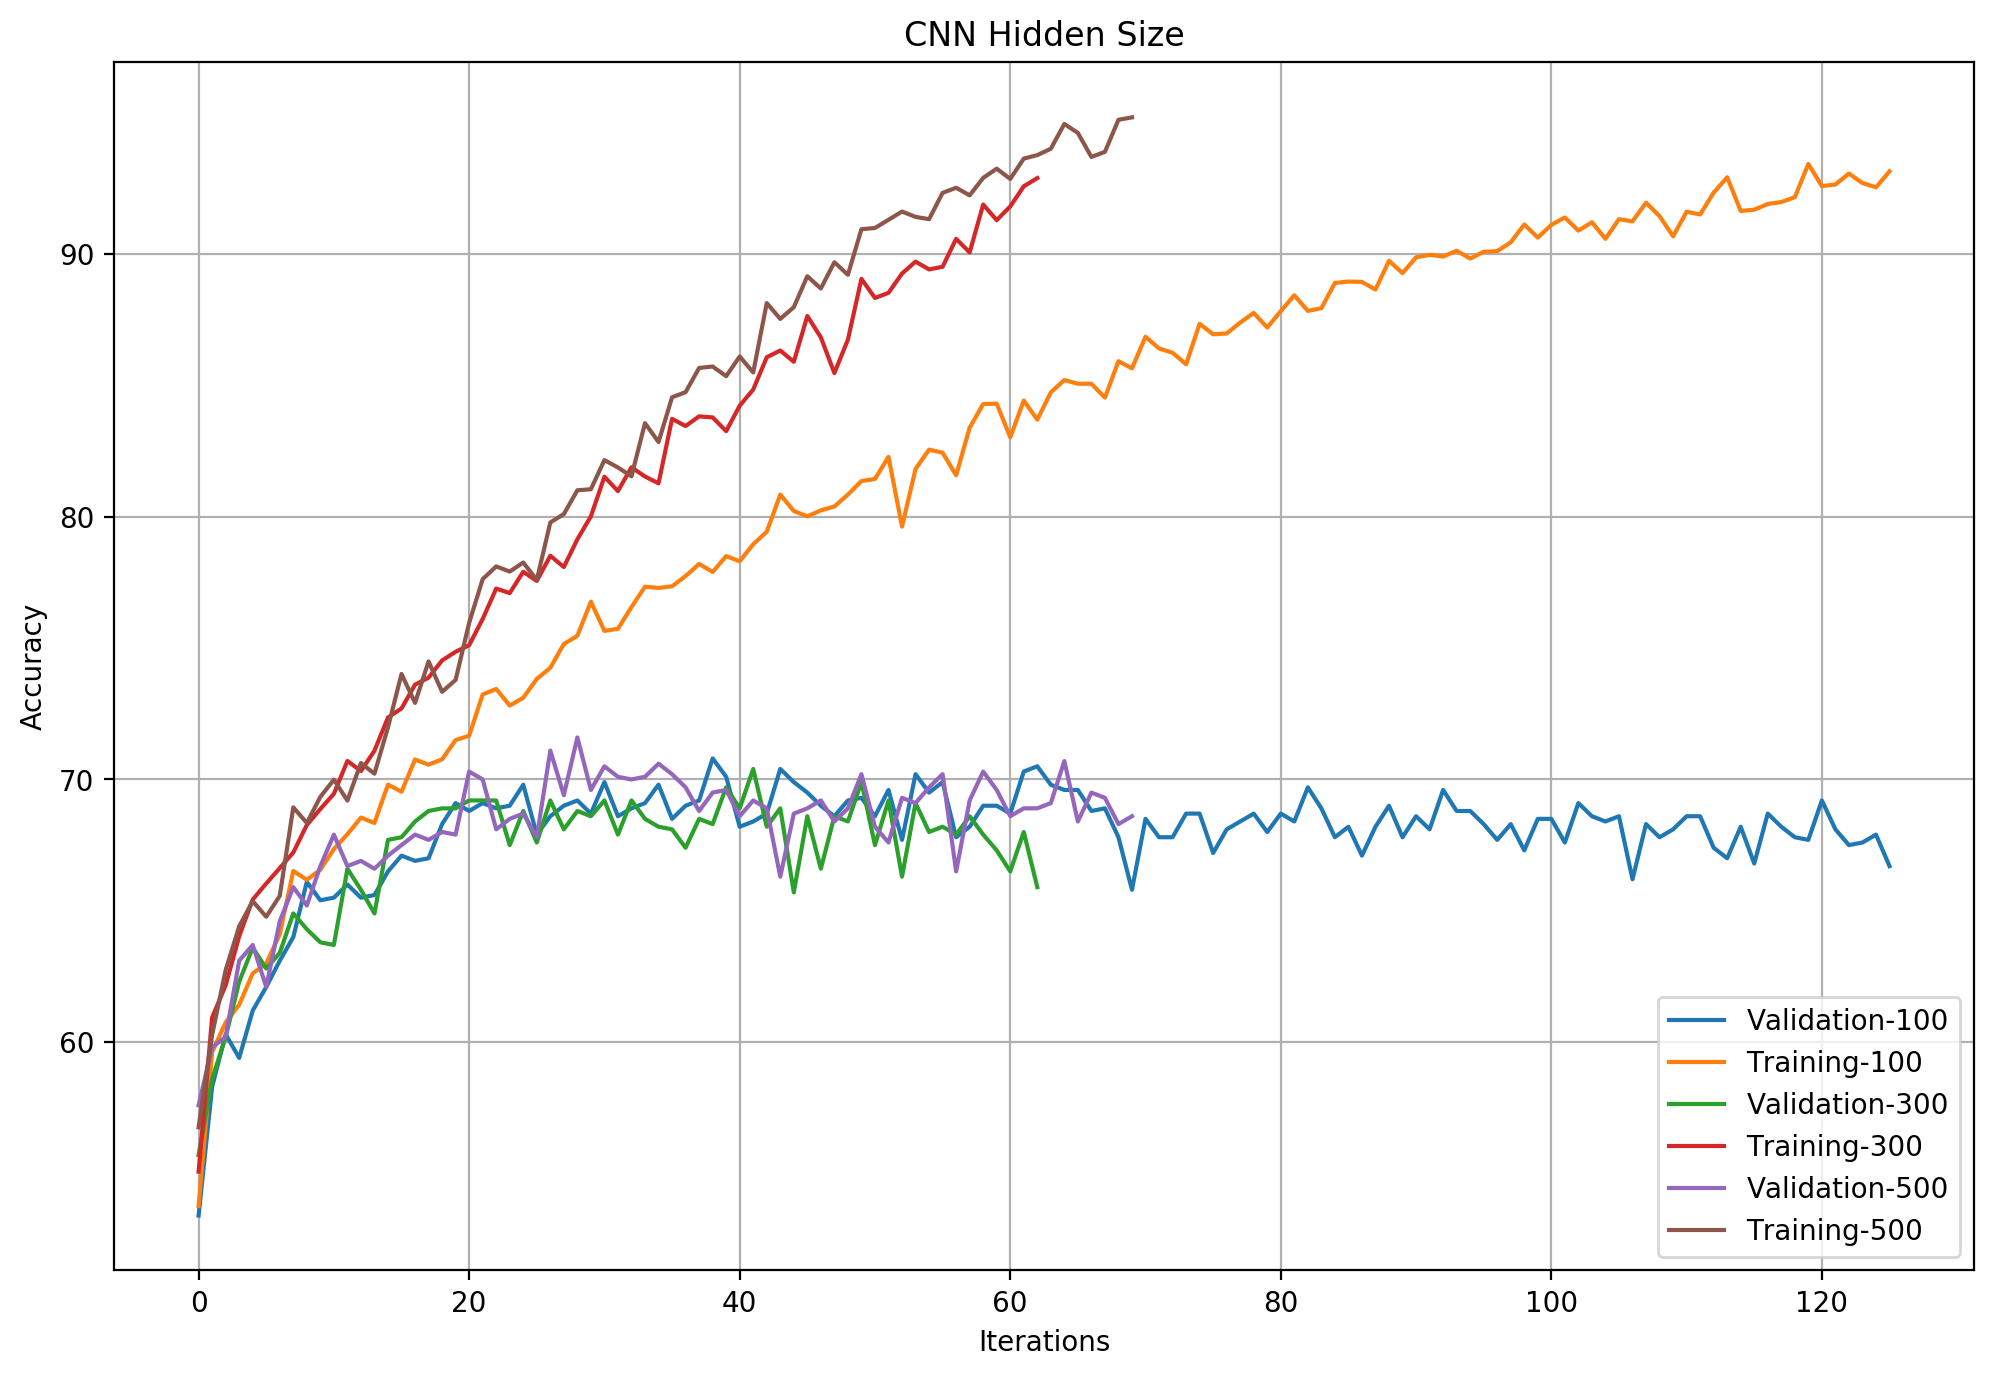

In [26]:

figure(num=None, figsize=(12, 8), dpi=200)
plt.plot(fine_tuning_CNN['val_acc']['100'])
plt.plot(fine_tuning_CNN['train_acc']['100'])
plt.plot(fine_tuning_CNN['val_acc']['300'])
plt.plot(fine_tuning_CNN['train_acc']['300'])
plt.plot(fine_tuning_CNN['val_acc']['500'])
plt.plot(fine_tuning_CNN['train_acc']['500'])
plt.ylabel('Accuracy')
plt.xlabel('Iterations')

plt.title('CNN Hidden Size')
plt.legend(('Validation-100','Training-100','Validation-300','Training-300','Validation-500','Training-500'),loc = 'lower right')
plt.grid()
plt.show()

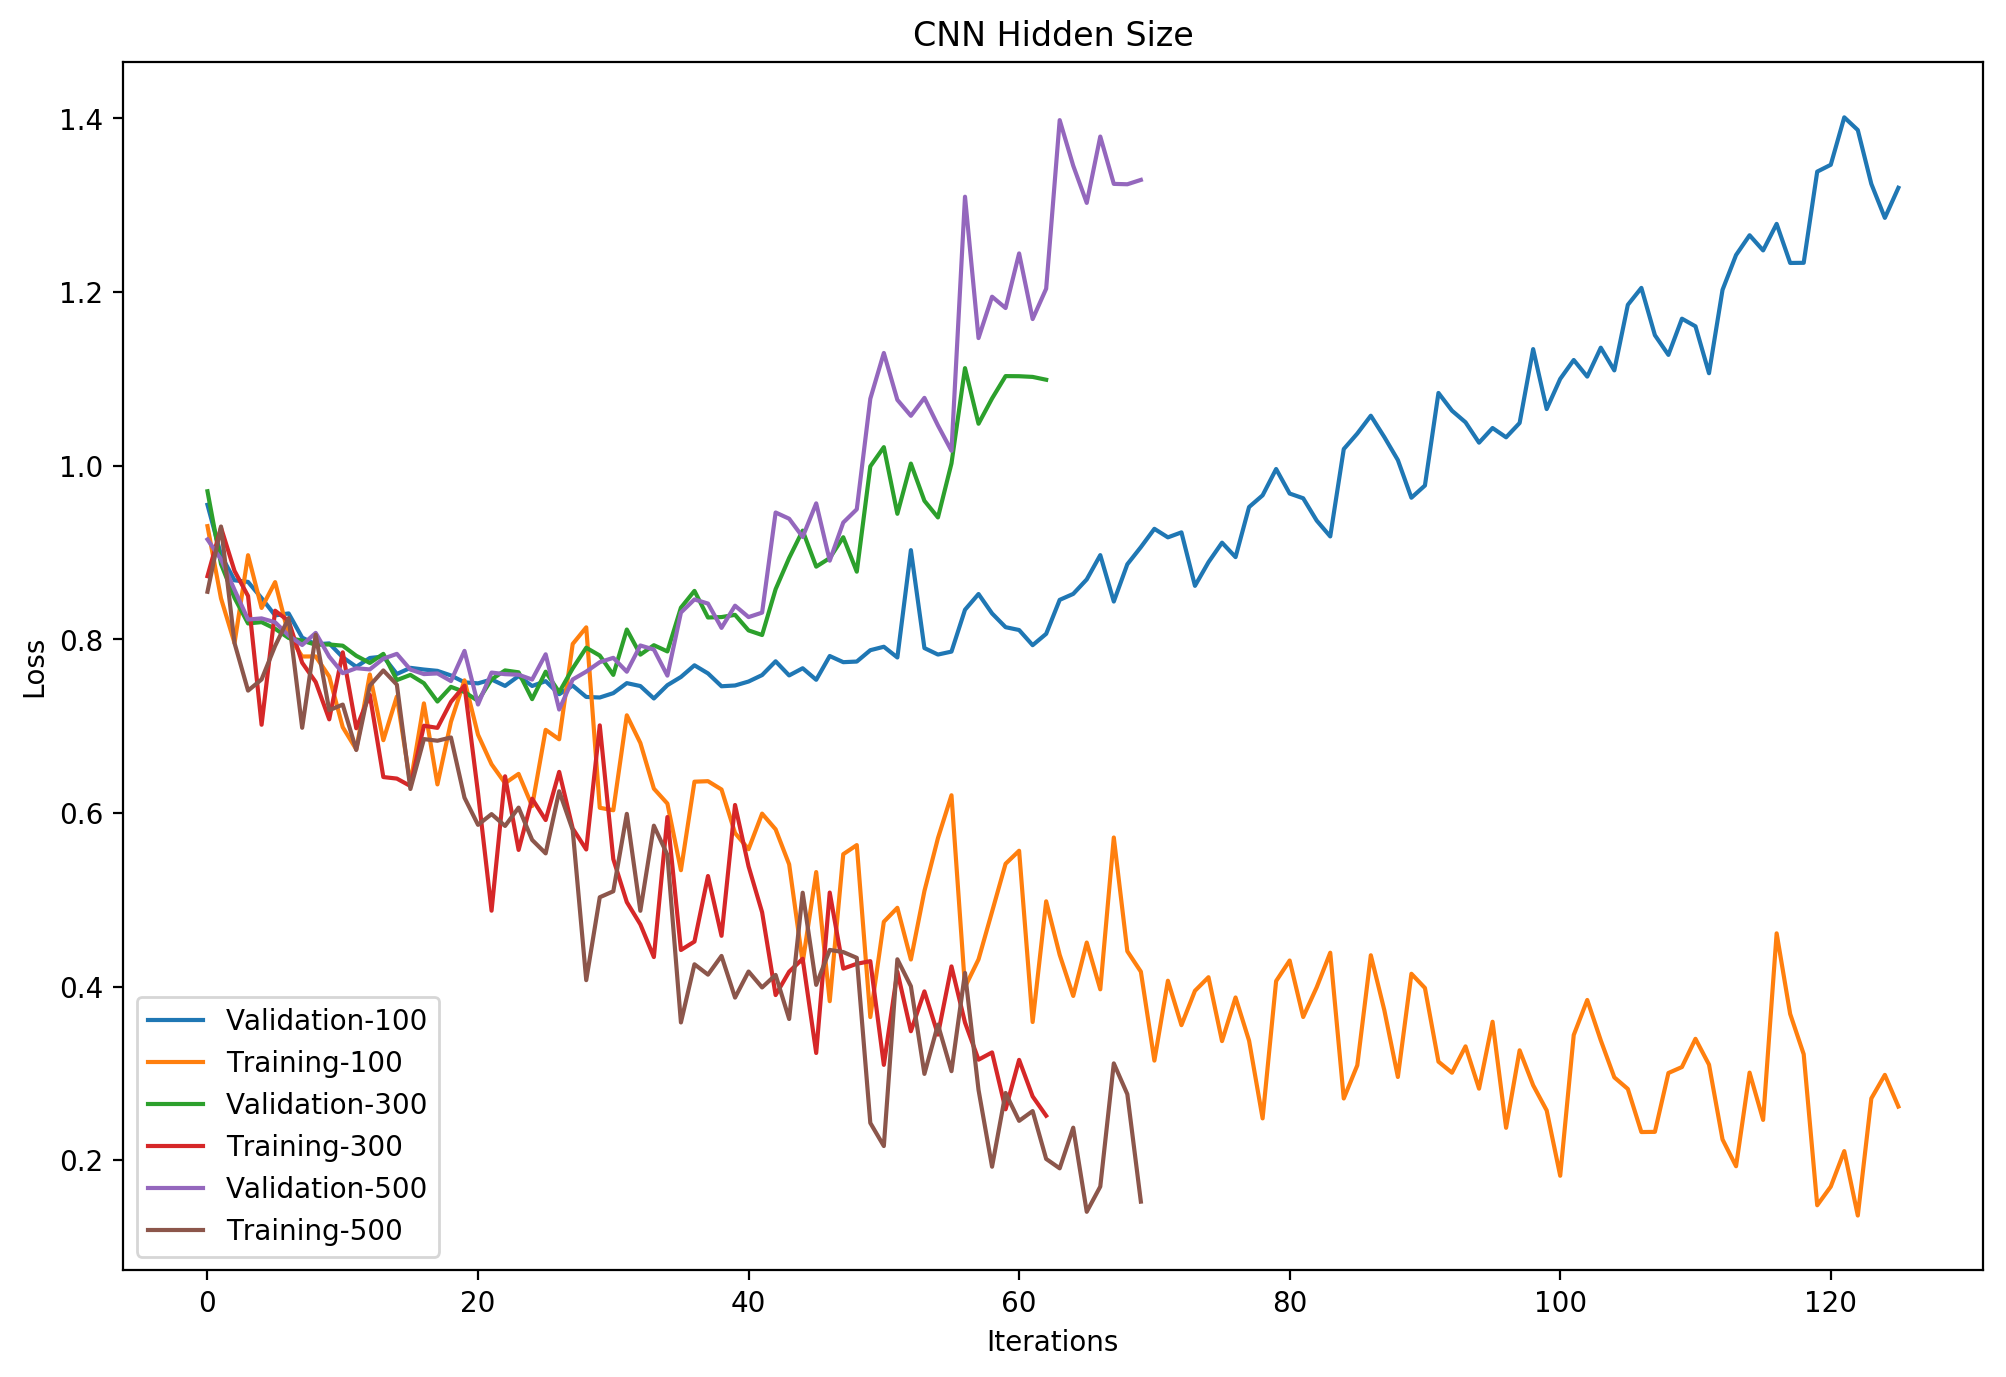

In [29]:
figure(num=None, figsize=(12, 8), dpi=200)
plt.plot(fine_tuning_CNN['val_loss']['100'])
plt.plot(fine_tuning_CNN['train_loss']['100'])
plt.plot(fine_tuning_CNN['val_loss']['300'])
plt.plot(fine_tuning_CNN['train_loss']['300'])
plt.plot(fine_tuning_CNN['val_loss']['500'])
plt.plot(fine_tuning_CNN['train_loss']['500'])
plt.ylabel('Loss')
plt.xlabel('Iterations')
plt.title('CNN Hidden Size')
plt.legend(('Validation-100','Training-100','Validation-300','Training-300','Validation-500','Training-500'),loc = 'lower left')
plt.show()

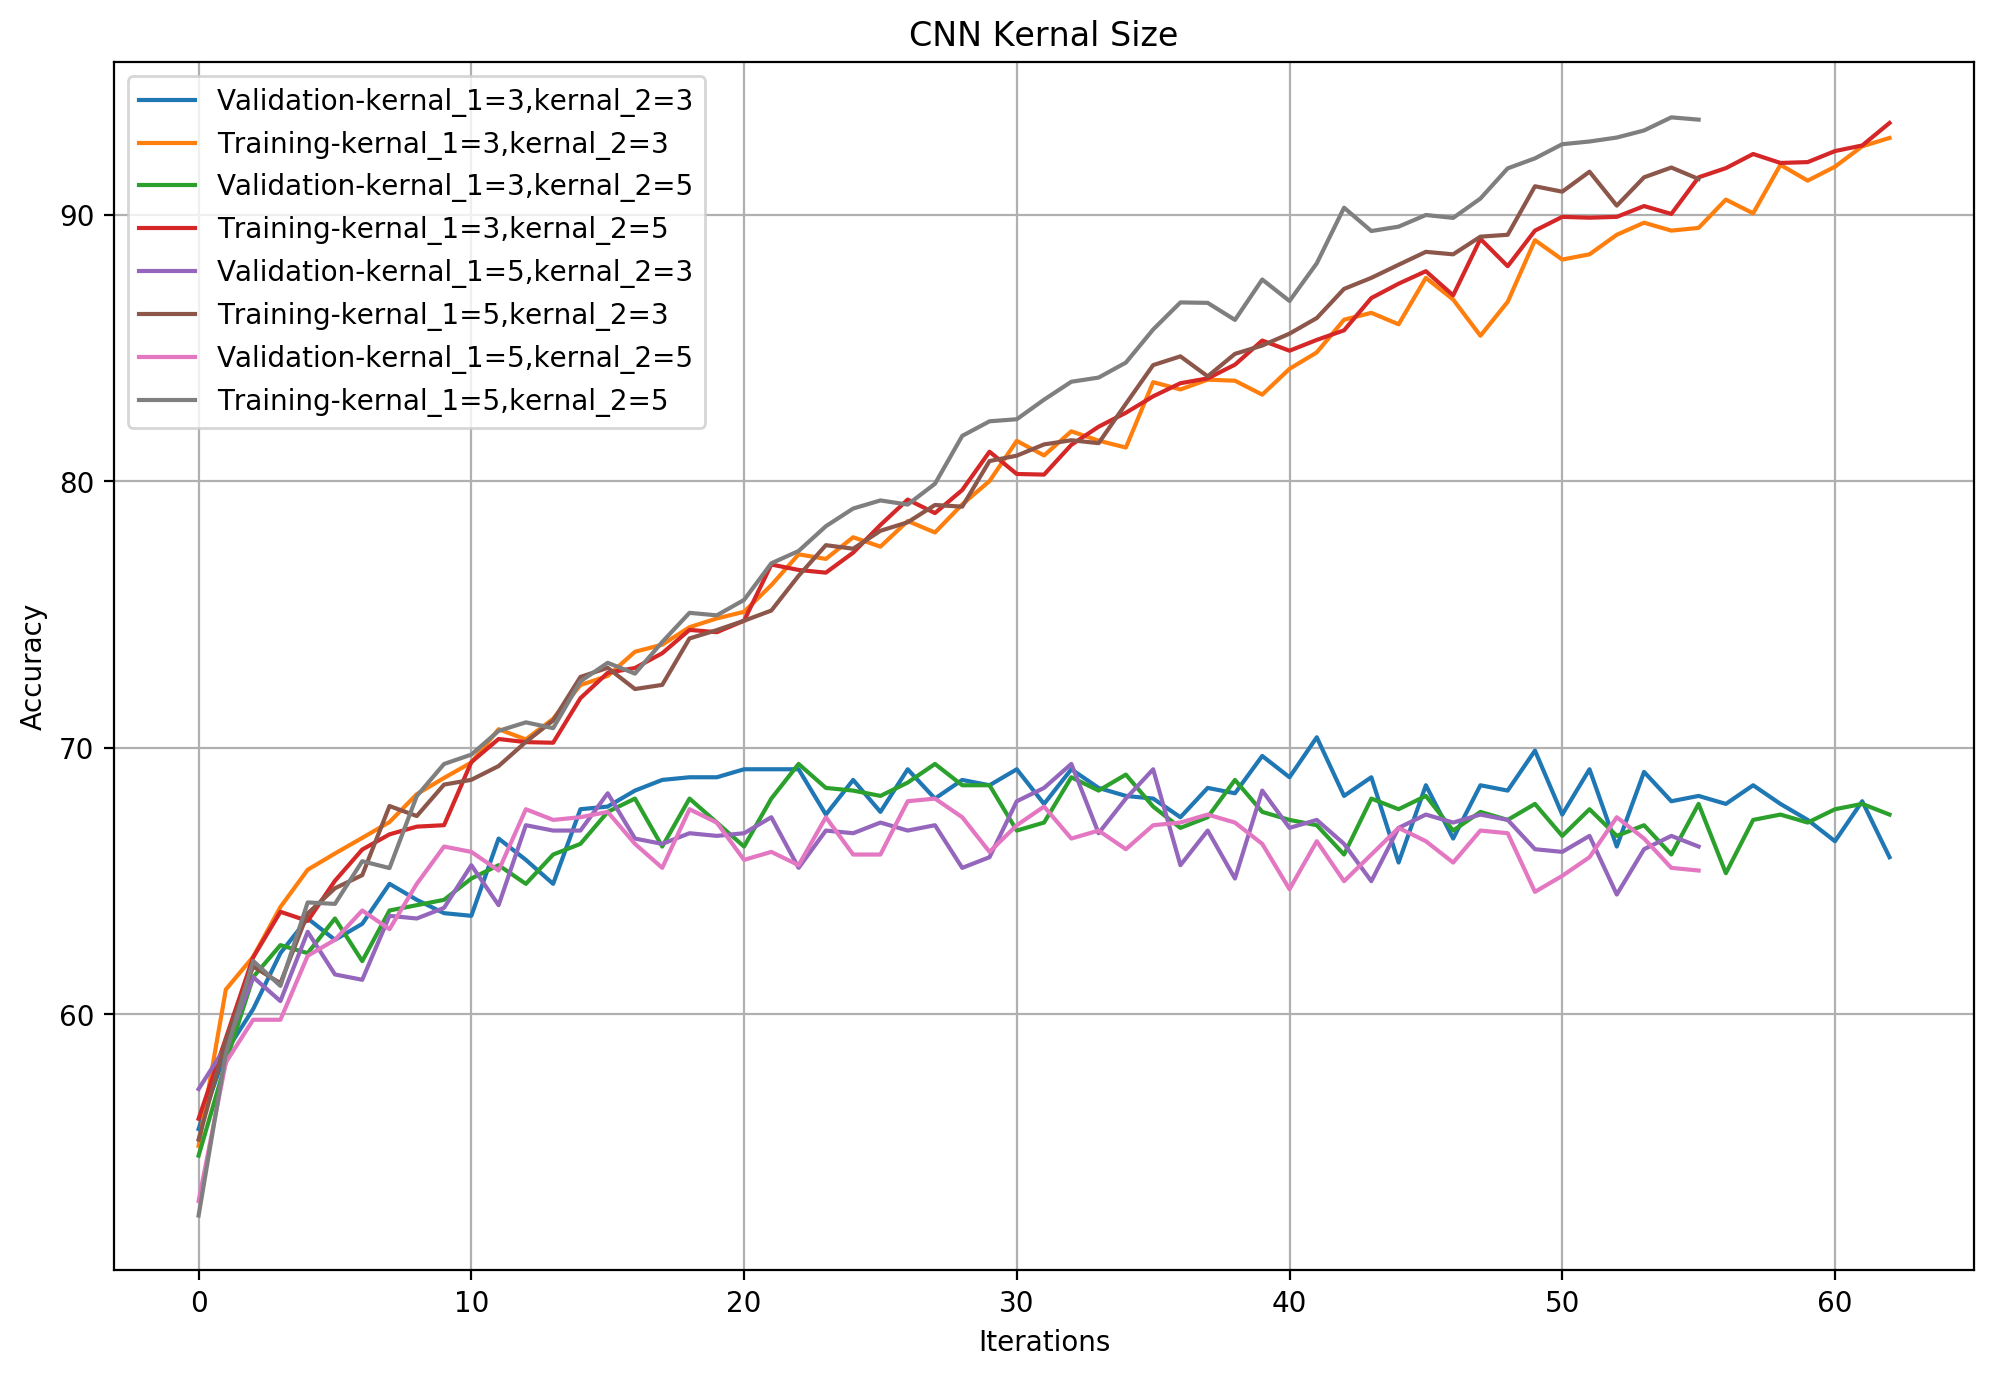

In [37]:

figure(num=None, figsize=(12, 8), dpi=200)
plt.plot(fine_tuning_CNN['val_acc']['300'])
plt.plot(fine_tuning_CNN['train_acc']['300'])
plt.plot(fine_tuning_CNN['val_acc']['300,k=3,5'])
plt.plot(fine_tuning_CNN['train_acc']['300,k=3,5'])
plt.plot(fine_tuning_CNN['val_acc']['300,k=5,3'])
plt.plot(fine_tuning_CNN['train_acc']['300,k=5,3'])
plt.plot(fine_tuning_CNN['val_acc']['300,k=5,5'])
plt.plot(fine_tuning_CNN['train_acc']['300,k=5,5'])
plt.ylabel('Accuracy')
plt.xlabel('Iterations')

plt.title('CNN Kernal Size')
plt.legend(('Validation-kernal_1=3,kernal_2=3','Training-kernal_1=3,kernal_2=3',
            'Validation-kernal_1=3,kernal_2=5','Training-kernal_1=3,kernal_2=5',
            'Validation-kernal_1=5,kernal_2=3','Training-kernal_1=5,kernal_2=3',
           'Validation-kernal_1=5,kernal_2=5','Training-kernal_1=5,kernal_2=5'),loc = 'upper left')
plt.grid()
plt.show()

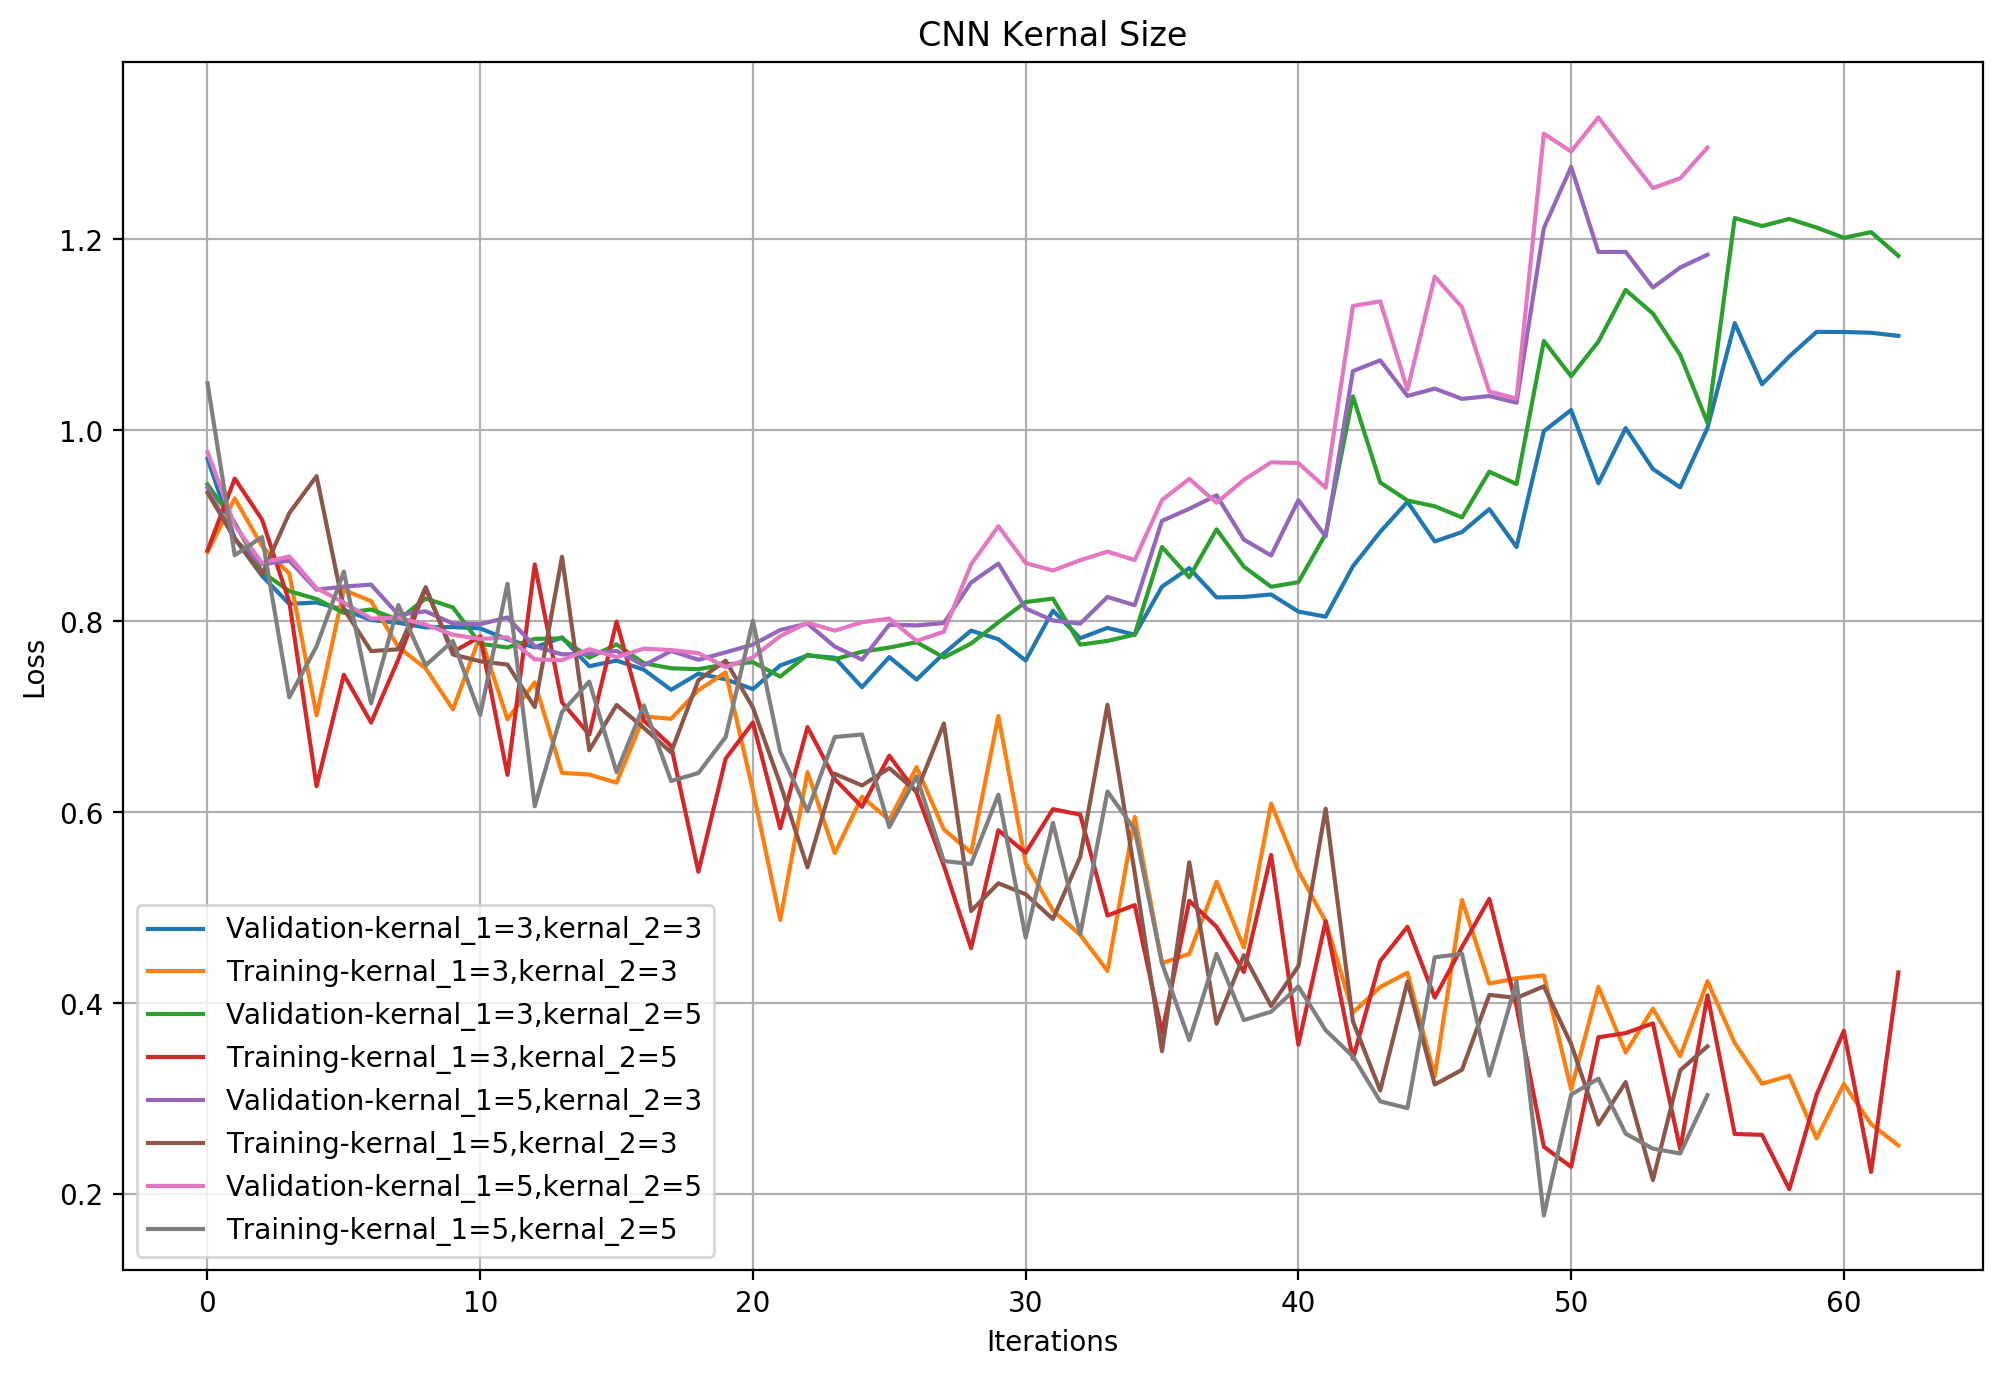

In [39]:

figure(num=None, figsize=(12, 8), dpi=200)
plt.plot(fine_tuning_CNN['val_loss']['300'])
plt.plot(fine_tuning_CNN['train_loss']['300'])
plt.plot(fine_tuning_CNN['val_loss']['300,k=3,5'])
plt.plot(fine_tuning_CNN['train_loss']['300,k=3,5'])
plt.plot(fine_tuning_CNN['val_loss']['300,k=5,3'])
plt.plot(fine_tuning_CNN['train_loss']['300,k=5,3'])
plt.plot(fine_tuning_CNN['val_loss']['300,k=5,5'])
plt.plot(fine_tuning_CNN['train_loss']['300,k=5,5'])
plt.ylabel('Loss')
plt.xlabel('Iterations')

plt.title('CNN Kernal Size')
plt.legend(('Validation-kernal_1=3,kernal_2=3','Training-kernal_1=3,kernal_2=3',
            'Validation-kernal_1=3,kernal_2=5','Training-kernal_1=3,kernal_2=5',
            'Validation-kernal_1=5,kernal_2=3','Training-kernal_1=5,kernal_2=3',
           'Validation-kernal_1=5,kernal_2=5','Training-kernal_1=5,kernal_2=5'),loc = 'lower left')
plt.grid()
plt.show()

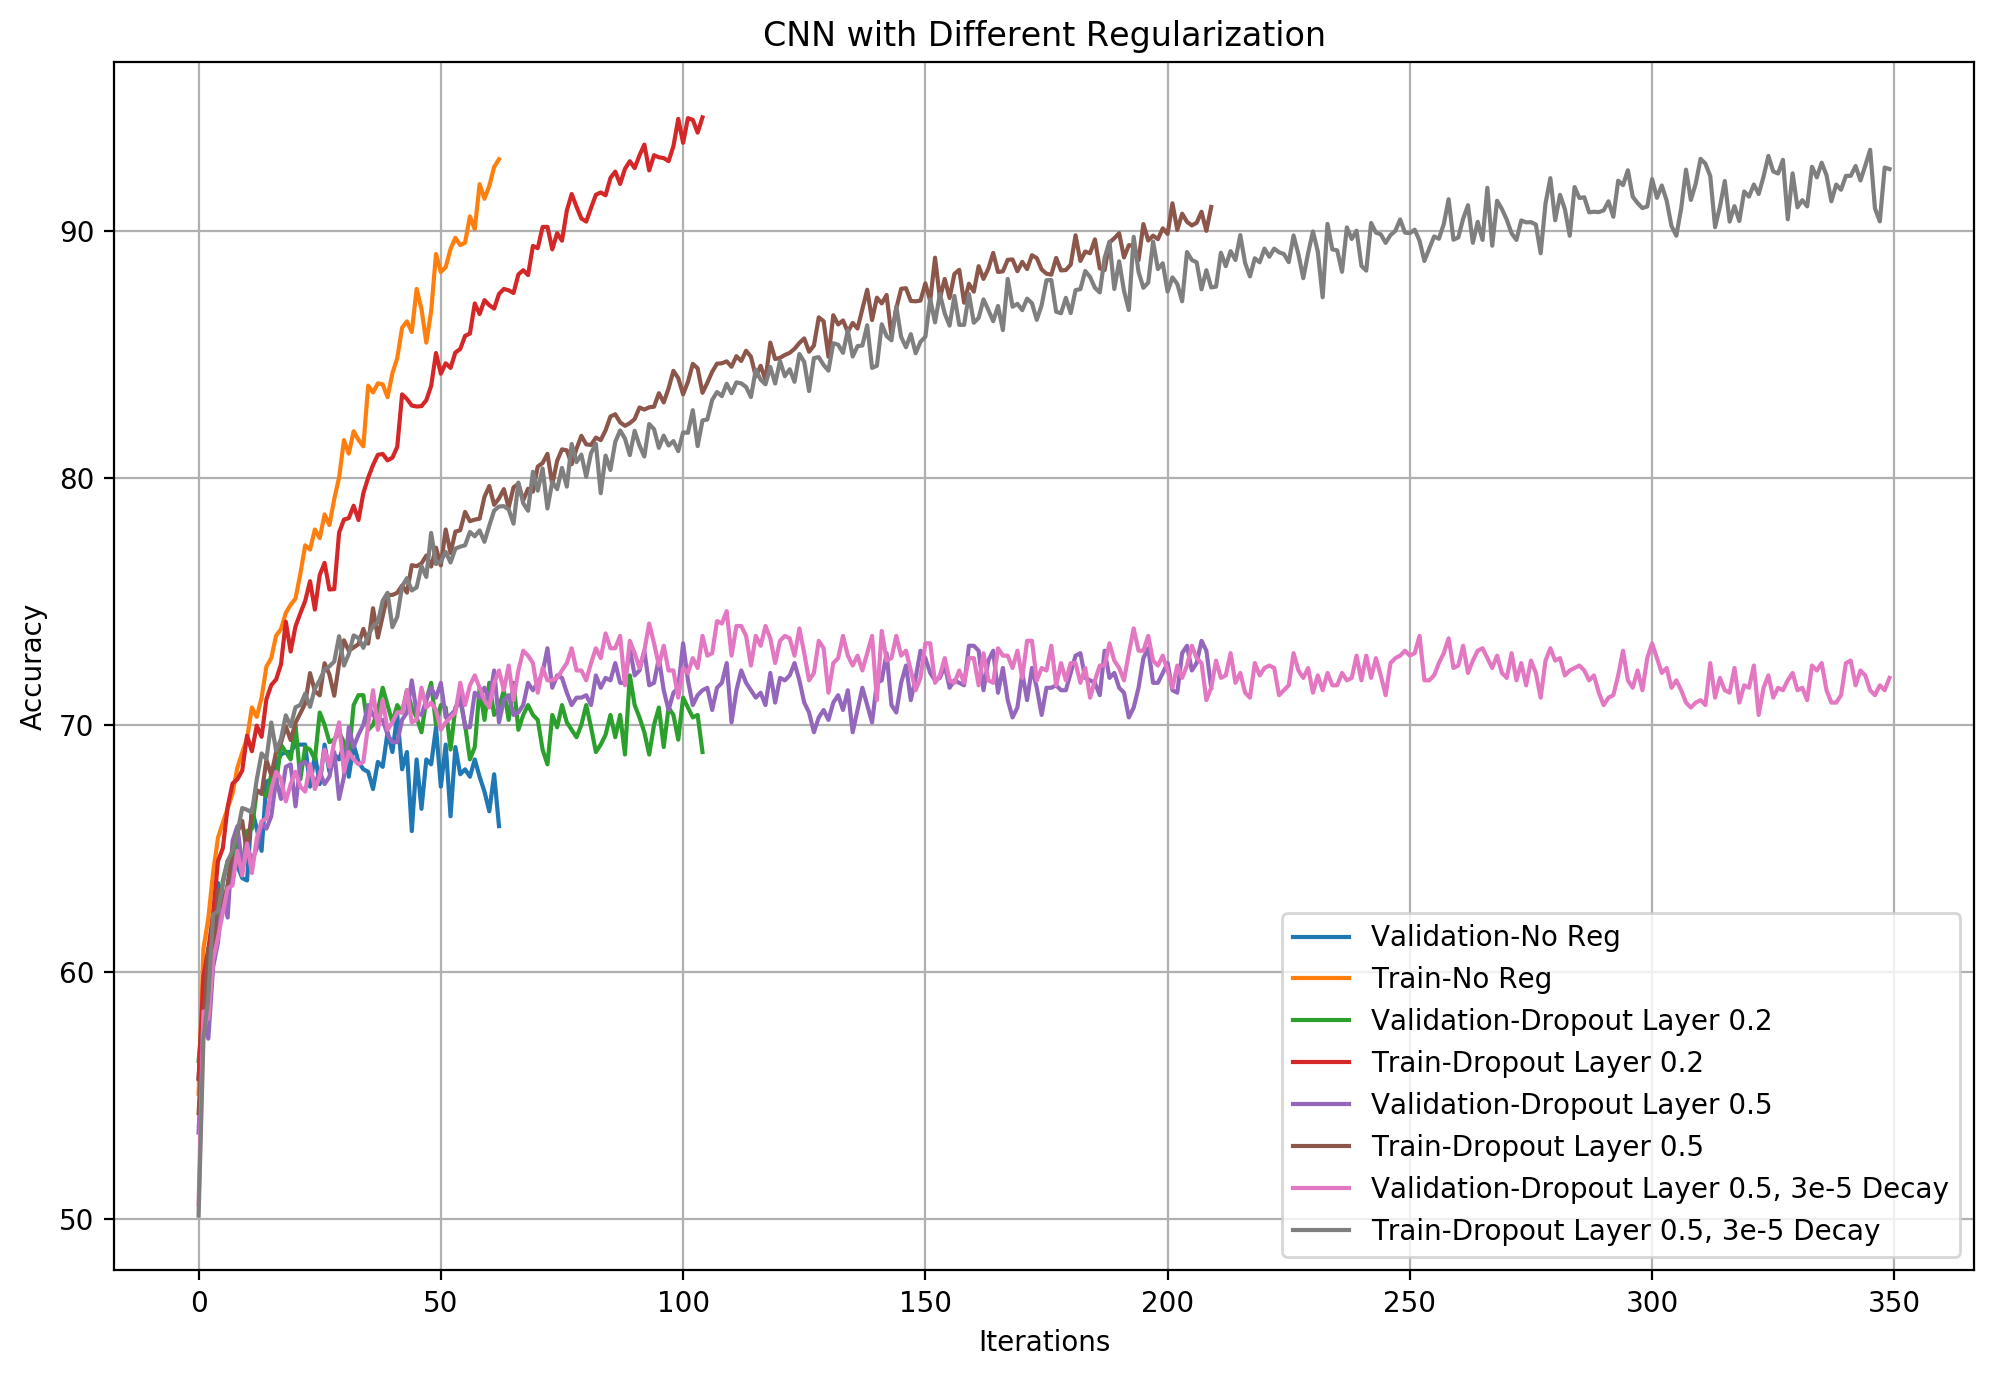

In [50]:
figure(num=None, figsize=(12, 8), dpi=200)
plt.plot(fine_tuning_CNN['val_acc']['300'])
plt.plot(fine_tuning_CNN['train_acc']['300'])
plt.plot(fine_tuning_CNN['val_acc']['300,drop_1=0.2'])
plt.plot(fine_tuning_CNN['train_acc']['300,drop_1=0.2'])
plt.plot(fine_tuning_CNN['val_acc']['300,drop_1=0.5'])
plt.plot(fine_tuning_CNN['train_acc']['300,drop_1=0.5'])
plt.plot(fine_tuning_CNN['val_acc']['300,drop_1=0.5,decay=1e-5'])
plt.plot(fine_tuning_CNN['train_acc']['300,drop_1=0.5,decay=1e-5'])
plt.title('CNN with Different Regularization')
plt.legend(('Validation-No Reg','Train-No Reg','Validation-Dropout Layer 0.2','Train-Dropout Layer 0.2',
           'Validation-Dropout Layer 0.5','Train-Dropout Layer 0.5',
           'Validation-Dropout Layer 0.5, 3e-5 Decay','Train-Dropout Layer 0.5, 3e-5 Decay'),loc='lower right')
plt.ylabel('Accuracy')
plt.xlabel('Iterations')
plt.grid()
plt.show()

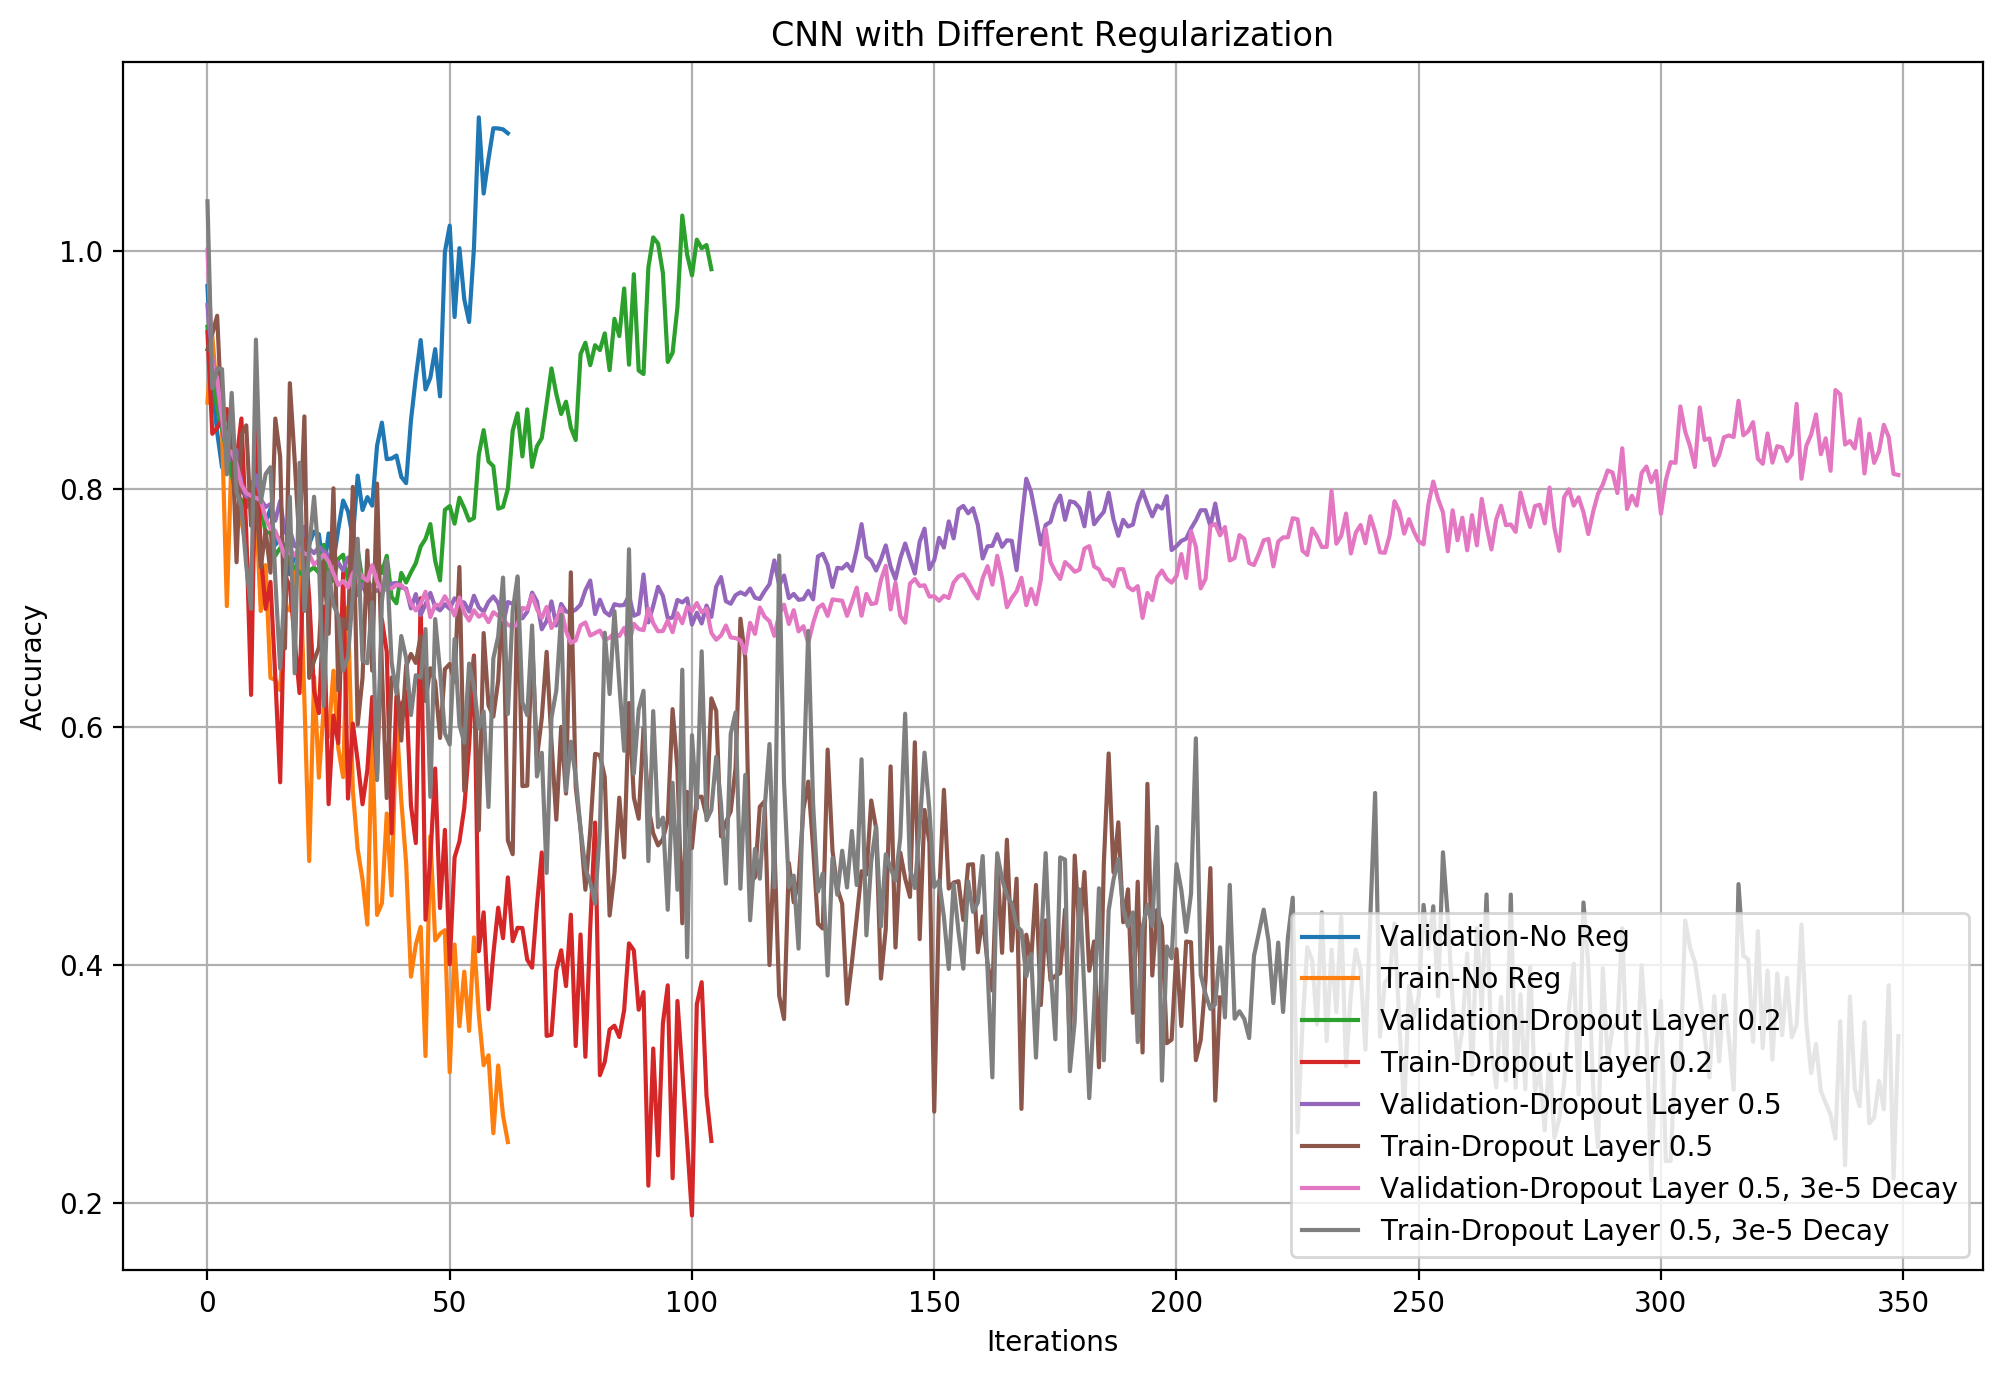

In [51]:
figure(num=None, figsize=(12, 8), dpi=200)
plt.plot(fine_tuning_CNN['val_loss']['300'])
plt.plot(fine_tuning_CNN['train_loss']['300'])
plt.plot(fine_tuning_CNN['val_loss']['300,drop_1=0.2'])
plt.plot(fine_tuning_CNN['train_loss']['300,drop_1=0.2'])
plt.plot(fine_tuning_CNN['val_loss']['300,drop_1=0.5'])
plt.plot(fine_tuning_CNN['train_loss']['300,drop_1=0.5'])
plt.plot(fine_tuning_CNN['val_loss']['300,drop_1=0.5,decay=1e-5'])
plt.plot(fine_tuning_CNN['train_loss']['300,drop_1=0.5,decay=1e-5'])
plt.title('CNN with Different Regularization')
plt.legend(('Validation-No Reg','Train-No Reg','Validation-Dropout Layer 0.2','Train-Dropout Layer 0.2',
           'Validation-Dropout Layer 0.5','Train-Dropout Layer 0.5',
           'Validation-Dropout Layer 0.5, 3e-5 Decay','Train-Dropout Layer 0.5, 3e-5 Decay'),loc='lower right')
plt.ylabel('Accuracy')
plt.xlabel('Iterations')
plt.grid()
plt.show()

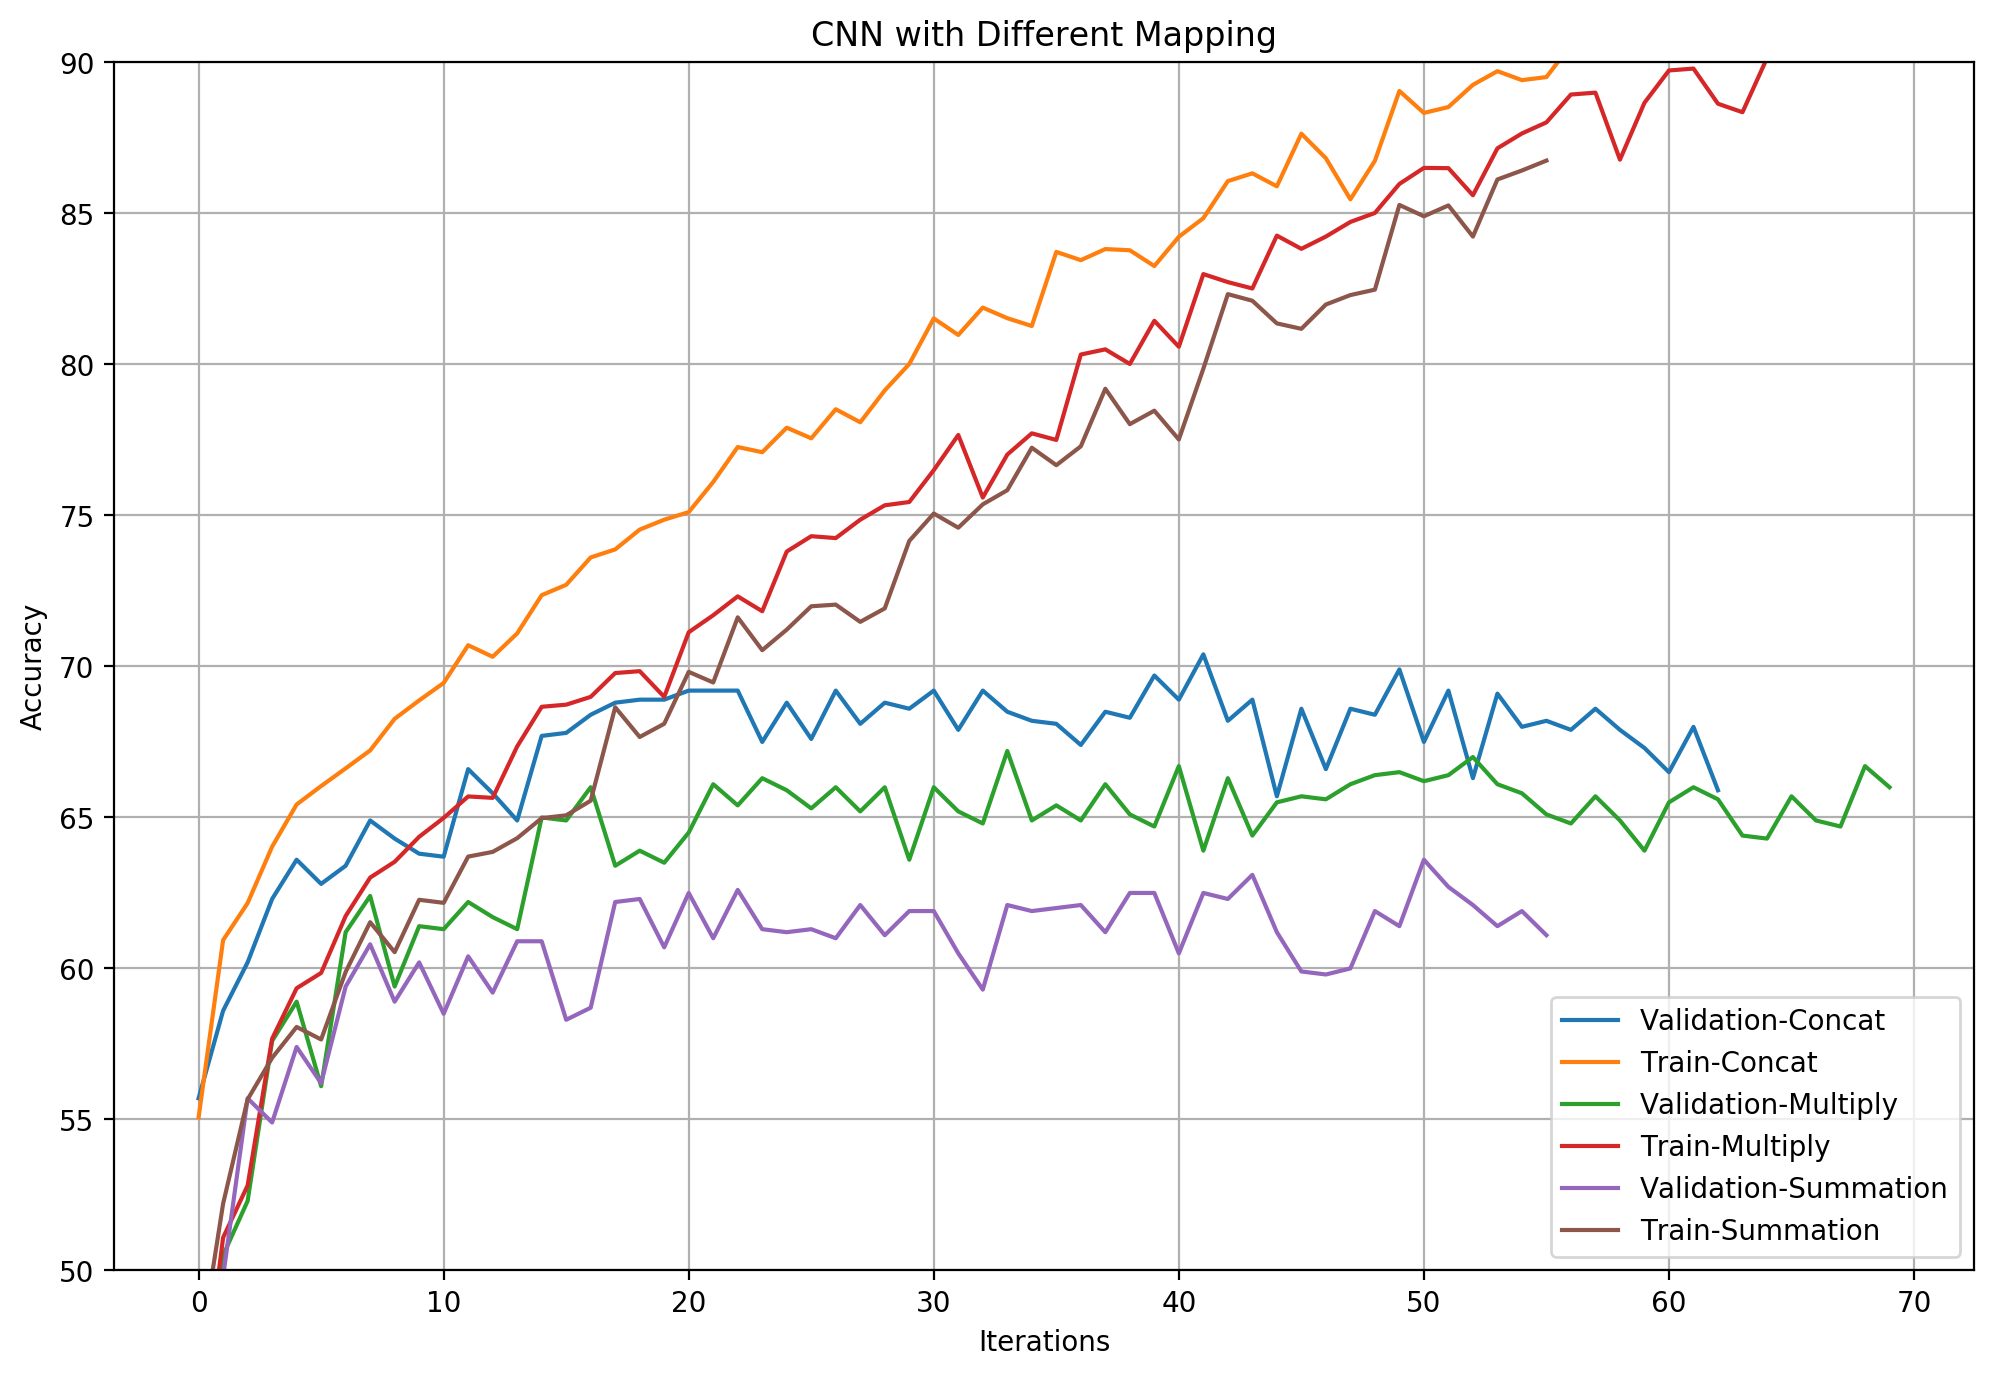

In [15]:

figure(num=None, figsize=(12, 8), dpi=200)
plt.plot(fine_tuning_CNN['val_acc']['300'])
plt.plot(fine_tuning_CNN['train_acc']['300'])
plt.plot(fine_tuning_CNN['val_acc']['300,mult'])
plt.plot(fine_tuning_CNN['train_acc']['300,mult'])
plt.plot(fine_tuning_CNN['val_acc']['300,sum'])
plt.plot(fine_tuning_CNN['train_acc']['300,sum'])
plt.title('CNN with Different Mapping')
plt.legend(('Validation-Concat','Train-Concat','Validation-Multiply','Train-Multiply',
            'Validation-Summation','Train-Summation'),loc='lower right')
plt.ylabel('Accuracy')
plt.xlabel('Iterations')
plt.grid()
plt.ylim((50,90))
plt.show()

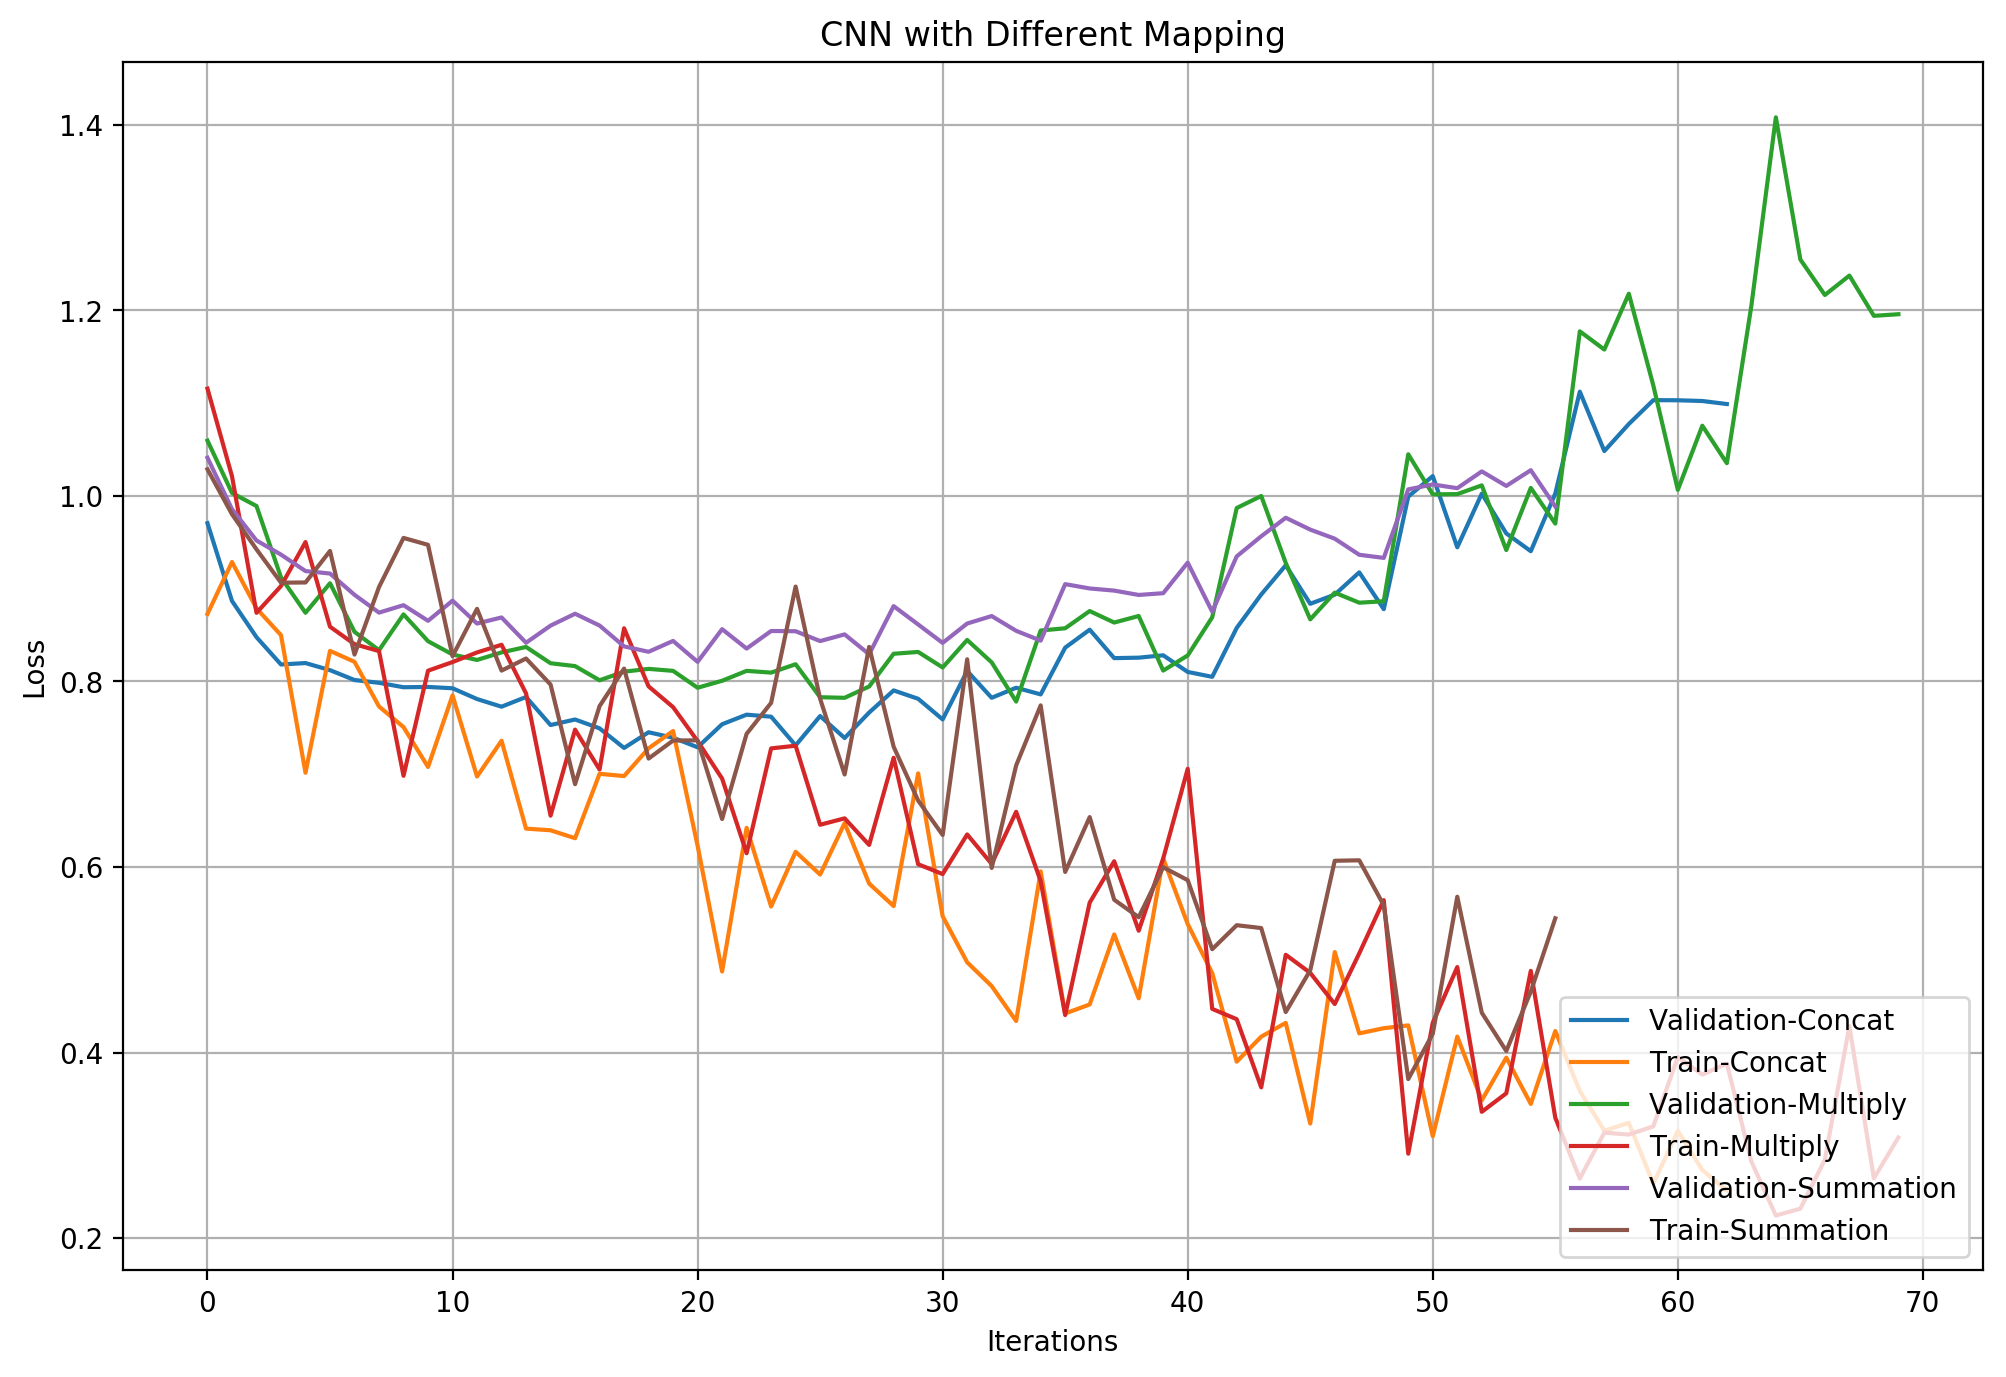

In [16]:
figure(num=None, figsize=(12, 8), dpi=200)
plt.plot(fine_tuning_CNN['val_loss']['300'])
plt.plot(fine_tuning_CNN['train_loss']['300'])
plt.plot(fine_tuning_CNN['val_loss']['300,mult'])
plt.plot(fine_tuning_CNN['train_loss']['300,mult'])
plt.plot(fine_tuning_CNN['val_loss']['300,sum'])
plt.plot(fine_tuning_CNN['train_loss']['300,sum'])
plt.title('CNN with Different Mapping')
plt.legend(('Validation-Concat','Train-Concat','Validation-Multiply','Train-Multiply',
            'Validation-Summation','Train-Summation'),loc='lower right')
plt.ylabel('Loss')
plt.xlabel('Iterations')
plt.grid()
plt.show()

## Report training and validation accuracy of best model for RNN and CNN

In [11]:
def test_model_rnn(loader, model):
    correct = 0
    total = 0
    model.eval()
    for data_1, data_2, lengths_1, lengths_2, labels in loader:
        data_batch_1,data_batch_2, lengths_batch_1,lengths_batch_2, label_batch = data_1, data_2, lengths_1, lengths_2, labels
        data_batch_1 = data_batch_1.long()
        data_batch_2 = data_batch_2.long()
        outputs = F.softmax(model(data_batch_1, data_batch_2, lengths_batch_1,lengths_batch_2), dim=1)
        predicted = outputs.max(1, keepdim=True)[1]
        total += labels.size(0)
        correct += predicted.eq(labels.view_as(predicted)).sum().item()
    return (100 * correct / total)

def test_model_cnn(loader, model):
    count = 0
    correct = 0
    total = 0
    model.eval()
    for data_1, data_2, lengths_1, lengths_2, labels in loader:
        data_batch_1,data_batch_2, lengths_batch_1, lengths_batch_2, label_batch = data_1, data_2, lengths_1, lengths_2, labels
        data_batch_1 = data_batch_1.long()
        data_batch_2 = data_batch_2.long()
        outputs = F.softmax(model(data_batch_1, data_batch_2), dim=1)
        predicted = outputs.max(1, keepdim=True)[1]
        total += labels.size(0)
        correct += predicted.eq(labels.view_as(predicted)).sum().item()
    return (100 * correct / total)

In [12]:
device = torch.device('cuda')
rnn_model = RNN(weights_matrix=pre_trained_embedding, input_size=300, hidden_size=300, num_layers=1, num_classes=3)
rnn_model.to(device)
rnn_model.load_state_dict(torch.load('rnn_model.pt', map_location='cuda:0'))
val_acc = test_model_rnn(val_loader, rnn_model)
train_acc = test_model_rnn(train_loader, rnn_model)
print('The highest training accuarcy of my RNN model is: '+ str(train_acc))
print('The highest validation accuarcy of my RNN model is: '+ str(val_acc))

The highest training accuarcy of my RNN model is: 89.483
The highest validation accuarcy of my RNN model is: 75.0


In [18]:
cnn_model = CNN(weights_matrix=pre_trained_embedding, hidden_size=300, num_layers=1, num_classes=3)
cnn_model.to(device)
cnn_model.load_state_dict(torch.load('cnn_model.pt', map_location='cuda:0'))
val_acc = test_model_cnn(val_loader, cnn_model)
train_acc = test_model_cnn(train_loader, cnn_model)
print('The highest training accuarcy of my CNN model is: '+ str(train_acc))
print('The highest validation accuarcy of my CNN model is: '+ str(val_acc))

The highest training accuarcy of my CNN model is: 93.032
The highest validation accuarcy of my CNN model is: 73.8


In [113]:
def pred(loader, model):
    model.eval()
    result  = []
    y = []
    texts = []
    for data_1, data_2, lengths_1, lengths_2, labels in loader:
        data_batch_1,data_batch_2, length_batch_1,length_batch_2, label_batch = data_1, data_2, lengths_1, lengths_2, labels
        outputs = F.softmax(model(data_batch_1,data_batch_2,length_batch_1,length_batch_2), dim=1)
        predicted = outputs.max(1, keepdim=True)[1].tolist()
        result.extend(predicted)
        y.extend(label_batch.tolist())
        texts.extend(data_batch_1.tolist())
    return result, y, texts
pred_loader = torch.utils.data.DataLoader(dataset=val_dataset, 
                                           batch_size=BATCH_SIZE,
                                           collate_fn=snli_collate_func,
                                           shuffle=False)
# 1:entailment
# 2:neutral
# 0:contradiction
y_pred, y_flag, texts= pred(pred_loader, rnn_model)
print([x[0] for x in y_pred[:20]])
print(y_flag[:20])
for row in texts[:20]:
    print(' '.join([idx2words_ft[i] for i in row if not i == 0]))
    print()

[0, 1, 0, 2, 0, 1, 2, 0, 1, 0, 1, 1, 1, 2, 1, 1, 2, 2, 1, 0]
[0, 0, 2, 0, 0, 1, 2, 0, 1, 1, 1, 1, 0, 2, 1, 1, 1, 1, 2, 2]
Three women on a stage , one wearing red shoes , black pants , and a gray shirt is sitting on a prop , another is sitting on the floor , and the third wearing a black shirt and pants is standing , as a gentleman in the back tunes an instrument .

A lone , 2-3 year old blond child in a blue jacket is putting a small black plastic item in his mouth as he <unk> on a waiting room couch pointed toward the back while looking at something or someone not in the room .

A group of people dressed in Santa Claus suits are looking towards an audience while a DJ runs a sound board and another person throws green balls into the air .

A kid in a red and black coat is laying on his back in the snow with his arm in the air and a red sled is next to him .

A ceremony with one man speaking and another man adjusting the robes on other person whose faces is partially covered being held

## Correct prediction

In [110]:
for i in [0,52,29]:
    row = SNLI_val.loc[i]
    print(row['label'] + ': --' + row['sentence1'] + '\t--' + row['sentence2'])

contradiction: --Three women on a stage , one wearing red shoes , black pants , and a gray shirt is sitting on a prop , another is sitting on the floor , and the third wearing a black shirt and pants is standing , as a gentleman in the back tunes an instrument .	--There are two women standing on the stage
entailment: --An Asian man in colorful robes holds a bell and leans toward a small table , with Buddhist or Hindu decorations on the table and the walls .	--An Asian man in colorful light robes holds a bell .
neutral: --Three cheerful ladies sitting at a table doing a yarn work in a room , at the background are similar groups of ladies doing similar work .	--The ladies are discussing what they are going to do tonight .


## Wrong prediction

In [116]:
#2, 3, 19
for i in [26, 17, 36]:
    row = SNLI_val.loc[i]
    print(row['label'] + ': \t--' + row['sentence1'] + '\t--' + row['sentence2'])
    print()

contradiction: 	--A lone , 2-3 year old blond child in a blue jacket is putting a small black plastic item in his mouth as he kneels on a waiting room couch pointed toward the back while looking at something or someone not in the room .	--The couch is pointed toward the front .

neutral: 	--A group of people dressed in Santa Claus suits are looking towards an audience while a DJ runs a sound board and another person throws green balls into the air .	--A band plays at a beach party .

neutral: 	--A woman walking a dog on a leash at the beach , trailing behind as a pug follows another unseen woman .	--a large woman walks a dog



## Test on MNLI Dataset grouped by genres

In [4]:
MNLI_train = pd.read_csv('mnli_train.tsv', sep= '\t')
MNLI_val = pd.read_csv('mnli_val.tsv', sep= '\t')
print('Train data setlength: ' + str(len(MNLI_train)))
print('Val dataset length: '+str(len(MNLI_val)))

MNLI_train.head()

Train data setlength: 20000
Val dataset length: 5000


sentence1  \
0  and now that was in fifty one that 's forty ye...   
1  Jon could smell baked bread on the air and his...   
2  it will be like Italian basketball with the uh...   
3  well i think that 's about uh that 's about co...   
4  Good job tenure , that is -- because in yet an...   

                                           sentence2          label      genre  
0  It was already a problem forty years ago but n...        neutral  telephone  
1         Jon smelt food in the air and was hungry .        neutral    fiction  
2  This type of Italian basketball is nothing lik...  contradiction  telephone  
3               Sorry but we are not done just yet .  contradiction  telephone  
4  Dr. Quinn , Medicine Woman , was worked on by ...     entailment      slate

In [13]:
MAX_SENTENCE_LENGTH=1000
class MNLIDataset(Dataset):

    def __init__(self, data_list_1, data_list_2, target_list):
  
        self.data_list_1 = data_list_1
        self.data_list_2 = data_list_2
        self.target_list = target_list
        assert (len(self.data_list_1) == len(self.data_list_2))

    def __len__(self):
        return len(self.data_list_1)
        
    def __getitem__(self, key):
        
        token_idx_1 = self.data_list_1[key][:MAX_SENTENCE_LENGTH]
        token_idx_2 = self.data_list_2[key][:MAX_SENTENCE_LENGTH]
        label = self.target_list[key]
        return [token_idx_1,token_idx_2, len(token_idx_1), len(token_idx_2) , label]

def snli_collate_func(batch):

    data_list_1 = []
    data_list_2 = []
    label_list = []
    length_list1 = []
    length_list2 = []
    for datum in batch:
        label_list.append(datum[4])
        length_list1.append(datum[2])
        length_list2.append(datum[3])
    # padding
    for datum in batch:
        padded_vec1 = np.pad(np.array(datum[0]), 
                                pad_width=((0,MAX_SENTENCE_LENGTH-datum[2])), 
                                mode="constant", constant_values=0)
        data_list_1.append(padded_vec1)
        padded_vec2 = np.pad(np.array(datum[1]), 
                                pad_width=((0,MAX_SENTENCE_LENGTH-len(datum[1]))), 
                                mode="constant", constant_values=0)
        data_list_2.append(padded_vec2)
    ind_dec_order = np.argsort(length_list1)[::-1]
    data_list_1 = np.array(data_list_1)[ind_dec_order]
    data_list_2 = np.array(data_list_2)[ind_dec_order]
    length_list_1 = np.array(length_list1)[ind_dec_order]
    length_list_2 = np.array(length_list2)[ind_dec_order]
    label_list = np.array(label_list)[ind_dec_order]
    
    return [torch.from_numpy(np.array(data_list_1)).to(device),
            torch.from_numpy(np.array(data_list_2)).to(device),
            torch.LongTensor(length_list_1).to(device),torch.LongTensor(length_list_2).to(device),
            torch.LongTensor(label_list).to(device)]

In [17]:
#0:contradiction, 1:entailment, 2:neutral
print(Counter(MNLI_train.genre))
print(Counter(MNLI_val.genre))
mnli_val_loader = Counter(MNLI_val.genre)
MNLI_val.loc[MNLI_val['label'] == 'contradiction','label'] = 0
MNLI_val.loc[MNLI_val['label'] == 'entailment','label'] = 1
MNLI_val.loc[MNLI_val['label'] == 'neutral','label'] = 2
device = torch.device('cuda')
rnn_model = RNN(weights_matrix=pre_trained_embedding, input_size=300, hidden_size=300, num_layers=1, num_classes=3)
rnn_model.to(device)
rnn_model.load_state_dict(torch.load('rnn_model.pt', map_location='cuda:0'))
cnn_model = CNN(weights_matrix=pre_trained_embedding, hidden_size=300, num_layers=1, num_classes=3)
cnn_model.to(device)
cnn_model.load_state_dict(torch.load('cnn_model.pt', map_location='cuda:0'))
for genre in Counter(MNLI_val.genre).keys():
    print(genre)
    sent1_indices_val = sentence2index_dataset(MNLI_val.loc[MNLI_val['genre'] == genre,'sentence1'].tolist())
    sent2_indices_val = sentence2index_dataset(MNLI_val.loc[MNLI_val['genre'] == genre,'sentence2'].tolist())
    y_val = MNLI_val.loc[MNLI_val['genre'] == genre,'label'].tolist()
    val_dataset_mnli = MNLIDataset(sent1_indices_val, sent2_indices_val, y_val)
    val_loader_mnli = torch.utils.data.DataLoader(dataset=val_dataset_mnli, 
                                           batch_size=32,
                                           collate_fn=snli_collate_func,
                                           shuffle=True)
    mnli_val_loader[genre] = val_loader_mnli
    print('The accuracy of genre '+genre+' are: \t' + 'RNN: '+ str(test_model_rnn(val_loader_mnli, rnn_model))
         + '\t CNN: '+ str(test_model_cnn(val_loader_mnli, cnn_model)))


Counter({'telephone': 4270, 'slate': 4026, 'travel': 3985, 'government': 3883, 'fiction': 3836})
Counter({'government': 1016, 'telephone': 1005, 'slate': 1002, 'fiction': 995, 'travel': 982})
fiction
The accuracy of genre fiction are: 	RNN: 48.54271356783919	 CNN: 49.64824120603015
telephone
The accuracy of genre telephone are: 	RNN: 46.56716417910448	 CNN: 51.940298507462686
slate
The accuracy of genre slate are: 	RNN: 44.71057884231537	 CNN: 44.91017964071856
government
The accuracy of genre government are: 	RNN: 45.47244094488189	 CNN: 49.311023622047244
travel
The accuracy of genre travel are: 	RNN: 43.38085539714868	 CNN: 50.712830957230146


## Fine Tuning on MNLI DataSet

In [35]:
mnli_train_loader = Counter(MNLI_train.genre)
MNLI_train.loc[MNLI_train['label'] == 'contradiction','label'] = 0
MNLI_train.loc[MNLI_train['label'] == 'entailment','label'] = 1
MNLI_train.loc[MNLI_train['label'] == 'neutral','label'] = 2
for genre in Counter(MNLI_val.genre).keys():
    print(genre)
    sent1_indices_train = sentence2index_dataset(MNLI_train.loc[MNLI_train['genre'] == genre,'sentence1'].tolist())
    sent2_indices_train = sentence2index_dataset(MNLI_train.loc[MNLI_train['genre'] == genre,'sentence2'].tolist())
    y_train = MNLI_train.loc[MNLI_train['genre'] == genre,'label'].tolist()
    train_dataset_mnli = MNLIDataset(sent1_indices_train, sent2_indices_train, y_train)
    train_loader_mnli = torch.utils.data.DataLoader(dataset=train_dataset_mnli, 
                                           batch_size=32,
                                           collate_fn=snli_collate_func,
                                           shuffle=True)
    print(len(sent1_indices_train))
    mnli_train_loader[genre] = train_loader_mnli

fiction
3836
telephone
4270
slate
4026
government
3883
travel
3985


In [39]:
def train_for_genre(model, train_loader, val_loader, genre):
    learning_rate = 1e-3
    num_epochs = 30 # number epoch to train
    hyperparameter = 'best'
    # Criterion and Optimizer
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=0)
    PATH =  genre + '_cnn_model.pt'
    # Train the model
    total_step = len(train_loader)
    model.to(device)
    max_acc = 0
    for epoch in range(num_epochs):
        for i, (data_1, data_2, lengths_1, lengths_2, labels) in enumerate(train_loader):
            model.train()
            optimizer.zero_grad()
            # Forward pass
            data_1 = data_1.long()
            data_2 = data_2.long()
            outputs = model(data_1,data_2)
            labels = labels.long()
            loss = criterion(outputs, labels)
            # Backward and optimize
            loss.backward()
            optimizer.step()
            # validate every 100 iterations
            if i > 0 and i % 30 == 0:
                # validate
                val_acc = test_model_cnn(val_loader, model)
                pytorch_total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
#                 print('Epoch: [{}/{}], Step: [{}/{}], Validation Acc: {}, number of Para: {}'.format(
#                            epoch+1, num_epochs, i+1, len(train_loader), val_acc, pytorch_total_params))
                if val_acc > max_acc:
                    torch.save(model.state_dict(), PATH)
                    print(val_acc)
                    print('Better Model Saved')
                    max_acc = val_acc


In [5]:
for genre in Counter(MNLI_val.genre).keys():
    print(genre)
    device = torch.device('cuda')
    cnn_model = CNN(weights_matrix=pre_trained_embedding, hidden_size=300, num_layers=1, num_classes=3)
    cnn_model.to(device)
    cnn_model.load_state_dict(torch.load('cnn_model.pt', map_location='cuda:0'))
    prev_train_acc = test_model_cnn(mnli_train_loader[genre], cnn_model)
    prev_val_acc = test_model_cnn(mnli_val_loader[genre], cnn_model)
    train_for_genre(cnn_model,mnli_train_loader[genre],mnli_val_loader[genre],genre)
    genre_model =  CNN(weights_matrix=pre_trained_embedding, hidden_size=300, num_layers=1, num_classes=3)
    genre_model.to(device)
    genre_model.load_state_dict(torch.load(genre + '_cnn_model.pt', map_location='cuda:0'))
    curr_train_acc = test_model_cnn(mnli_train_loader[genre], genre_model)
    curr_val_acc = test_model_cnn(mnli_val_loader[genre], genre_model)
    print('Previous: Train-' + str(prev_train_acc) + ', Val-'+ str(prev_val_acc) + '; Current: Train-'+
         str(curr_train_acc) + ', Val-'+str(curr_val_acc))

fiction
telephone
slate
government
travel


In [38]:
for genre in Counter(MNLI_val.genre).keys():
    print(genre)
    device = torch.device('cuda')
    cnn_model = CNN(weights_matrix=pre_trained_embedding, hidden_size=300, num_layers=1, num_classes=3)
    cnn_model.to(device)
    cnn_model.load_state_dict(torch.load(genre+'_cnn_model.pt', map_location='cuda:0'))
    val = {}
    for genre_comp in Counter(MNLI_val.genre).keys():
        val_acc = test_model_cnn(mnli_val_loader[genre_comp],cnn_model)
        val[genre_comp] = val_acc
    print(val)

fiction
{'fiction': 55.57788944723618, 'telephone': 51.840796019900495, 'slate': 47.0059880239521, 'government': 52.55905511811024, 'travel': 51.425661914460285}
telephone
{'fiction': 53.768844221105525, 'telephone': 57.014925373134325, 'slate': 44.81037924151697, 'government': 51.27952755905512, 'travel': 51.425661914460285}
slate
{'fiction': 53.165829145728644, 'telephone': 52.23880597014925, 'slate': 49.00199600798403, 'government': 53.64173228346457, 'travel': 50.10183299389002}
government
{'fiction': 51.35678391959799, 'telephone': 55.223880597014926, 'slate': 46.8063872255489, 'government': 59.3503937007874, 'travel': 52.342158859470466}
travel
{'fiction': 51.35678391959799, 'telephone': 51.343283582089555, 'slate': 45.209580838323355, 'government': 53.838582677165356, 'travel': 55.39714867617108}
